In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import sys


# 0. Data preparation

In [2]:
### PLEASE CHANGE THE WORKING/FILE DIRECTORY! THANK YOU
#Set the working directory
os.chdir('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Documents\\Github repositories\\Predictive-Analytics-in-Business\\Project 2\\')

In [3]:
# # Step 1: Load the original Excel file
# file_path = 'crunchbase_data.xlsx'  # Replace with your file path

# # Step 2: Read each sheet into a separate DataFrame
# companies_df = pd.read_excel(file_path, sheet_name='Companies')
# rounds_df = pd.read_excel(file_path, sheet_name='Rounds')
# investments_df = pd.read_excel(file_path, sheet_name='Investments')
# acquisitions_df = pd.read_excel(file_path, sheet_name='Acquisitions')

# # Step 3: Save each DataFrame as a new Excel file
# companies_df.to_excel('Companies.xlsx', index=False)
# rounds_df.to_excel('Rounds.xlsx', index=False)
# investments_df.to_excel('Investments.xlsx', index=False)
# acquisitions_df.to_excel('Acquisitions.xlsx', index=False)

# Step 4: Loading the saved files (demonstration)
# You can load these files later as needed
df_org = pd.read_excel('Companies.xlsx')
df_rd = pd.read_excel('Rounds.xlsx')
df_inv = pd.read_excel('Investments.xlsx')
df_aq = pd.read_excel('Acquisitions.xlsx')


In [4]:
# Set up for date parser
date_cols_org = ['founded_at', 'first_funding_at', 'last_funding_at']
date_cols_inv_rd = ['funded_at']
date_cols_aq = ['acquired_at']

In [5]:
#shapes of al;l dfs
print('Original dataframes')
print(df_org.shape)
print(df_rd.shape)
print(df_inv.shape)
print(df_aq.shape)

Original dataframes
(49438, 18)
(83870, 16)
(114506, 24)
(13070, 22)


# 1. Data Cleaning

### 1.1 Limit the data to 1990 onwards

In [19]:
# Clean column names - get rid of extra whitespaces
df_rd = df_rd.rename(columns=lambda x: x.strip())
df_aq = df_aq.rename(columns=lambda x: x.strip())
df_org = df_org.rename(columns=lambda x: x.strip())
df_inv = df_inv.rename(columns=lambda x: x.strip())

In [23]:
# Create variables on quarters/months 
df_inv['funded_month'] = df_inv['funded_month'].str[-2:]
df_inv['funded_quarter'] = df_inv['funded_quarter'].str[-2:]

df_aq['acquired_month'] = df_aq['acquired_month'].str[-2:]
df_aq['acquired_quarter'] = df_aq['acquired_quarter'].str[-2:]

df_rd['funded_month'] = df_rd['funded_month'].str[-2:]
df_rd['funded_quarter'] = df_rd['funded_quarter'].str[-2:]

In [36]:
# Convert to datetime, setting out-of-bounds dates to NaT
df_org['founded_at'] = pd.to_datetime(df_org['founded_at'], format='%Y-%m-%d', errors='coerce')
df_rd['funded_at'] = pd.to_datetime(df_rd['funded_at'], format='%Y-%m-%d', errors='coerce')
df_inv['funded_year'] = pd.to_datetime(df_inv['funded_year'], format='%Y', errors='coerce')
df_aq['acquired_year'] = pd.to_datetime(df_aq['acquired_year'], format='%Y', errors='coerce')
df_aq['acquired_at'] = pd.to_datetime(df_aq['acquired_at'], format='%Y-%m-%d', errors='coerce')

# Optionally, remove rows where dates were set to NaT
df_org = df_org[df_org['founded_at'].notna()]
df_rd = df_rd[df_rd['funded_at'].notna()]
df_inv = df_inv[df_inv['funded_year'].notna()]
df_aq = df_aq[df_aq['acquired_year'].notna()]

In [37]:
#shapes of al;l dfs
print('Original dataframes')
print(df_org.shape)
print(df_rd.shape)
print(df_inv.shape)
print(df_aq.shape)

Original dataframes
(37402, 18)
(83821, 16)
(114475, 24)
(13041, 22)


In [38]:
#Limit the data to 1990 onwards
df_org = df_org[df_org['founded_at'] > '1990-01-01']
df_rd = df_rd[df_rd['funded_at'] > '1990-01-01']
df_inv = df_inv[df_inv['funded_year'] > '1989']
df_aq = df_aq[df_aq['acquired_year'] > '1989']


In [39]:
#shapes of al;l dfs
print('Data from 1990')
print(df_org.shape)
print(df_rd.shape)
print(df_inv.shape)
print(df_aq.shape)

Data from 1990
(37402, 18)
(83821, 16)
(114475, 24)
(13041, 22)


### 1.2 Empty rows and duplicates

In [41]:
# Drop rows that are fully empty
df_aq.dropna(axis=0, how='all', inplace=True)
df_inv.dropna(axis=0, how='all', inplace=True)
df_org.dropna(axis=0, how='all', inplace=True)
df_rd.dropna(axis=0, how='all', inplace=True)

In [42]:
# Get the shapes
print('Aquisitions: ', df_aq.shape)
print('Investments: ', df_inv.shape)
print('Organizations: ', df_org.shape)
print('Rounds: ', df_rd.shape)

Aquisitions:  (13041, 22)
Investments:  (114475, 24)
Organizations:  (37402, 18)
Rounds:  (83821, 16)


In [43]:
print('Fully duplicated rows')
print('AQ', df_aq.duplicated().sum())
print('INV', df_inv.duplicated().sum())
print('ORG', df_org.duplicated().sum())
print('RD', df_rd.duplicated().sum())

Fully duplicated rows
AQ 58
INV 0
ORG 0
RD 0


In [44]:
# Getting rid of 58 full duplicates
df_aq.drop_duplicates(inplace=True)

## Imputing each dataset separately and merging

### Organisations dataset

In [45]:
df_org.isna().sum()

permalink                0
name                     1
homepage_url          2039
category_list         1820
market                1825
funding_total_usd        0
status                 846
country_code          2986
state_code           13530
region                2986
city                  3409
funding_rounds           0
founded_at               0
founded_month            0
founded_quarter          0
founded_year             0
first_funding_at         0
last_funding_at          0
dtype: int64

This is the base dataset that all of the other datasets will be merged to. For now we will take care of the missing variables for state code and market. Status will be filled in once we merge the organisations and acquisitions dataset.  

In [48]:
# Drop rows with NA in Name
df_org.dropna(axis=0, subset=['name'], inplace=True)
# Drop rows with NA in country_code and city
df_org.dropna(axis=0, subset=['country_code'], inplace=True)
df_org.dropna(axis=0, subset=['city'], inplace=True)

# we notice that the state code is missing for non-US countries so we impute that data in
df_org['state_code'].fillna('non-US', inplace = True)

In [49]:
df_org.isna().sum()

permalink               0
name                    0
homepage_url         1862
category_list        1441
market               1443
funding_total_usd       0
status                740
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
founded_month           0
founded_quarter         0
founded_year            0
first_funding_at        0
last_funding_at         0
dtype: int64

### Rounds dataset

Since we are getting these datasets ready for merging, we subset it on the data that will be added to the organisations dataset. The other datapoints are already included in the organisations dataset.

In [51]:
rounds_sub = ['company_permalink', 'funding_round_permalink', 'funding_round_type', 'funding_round_code', 'funded_at', 'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd']
df_rd_sub = df_rd[rounds_sub]

In [52]:
df_rd_sub.isna().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         60962
funded_at                      0
funded_month                   0
funded_quarter                 0
funded_year                    0
raised_amount_usd          12799
dtype: int64

In [53]:
df_rd_sub['funded_at']= pd.to_datetime(df_rd_sub['funded_at'], format = '%Y-%m-%d')

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1530647838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funded_at']= pd.to_datetime(df_rd_sub['funded_at'], format = '%Y-%m-%d')


In [54]:
df_rd_sub['funded_month'] = df_rd_sub['funded_at'].dt.month
df_rd_sub['funded_year'] = df_rd_sub['funded_at'].dt.year
df_rd_sub['funded_quarter'] = df_rd_sub['funded_at'].dt.quarter

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\3765251328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funded_month'] = df_rd_sub['funded_at'].dt.month
C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\3765251328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funded_year'] = df_rd_sub['funded_at'].dt.year
C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\3765251328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [55]:
#filling in funding_round_code with the value unknown
df_rd_sub['funding_round_code'].fillna('Unknown', inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\3738850632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funding_round_code'].fillna('Unknown', inplace = True)


In [56]:
df_rd_sub.isna().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code             0
funded_at                      0
funded_month                   0
funded_quarter                 0
funded_year                    0
raised_amount_usd          12799
dtype: int64

#### First merge - organisations and rounds dataset

In [57]:
# Merge
df_merge_1 = pd.merge(df_org, df_rd_sub, how='left', left_on='permalink', right_on='company_permalink')

# Remove duplicate column from the right table
df_merge_1.drop('company_permalink', axis=1, inplace=True)

In [58]:
# converting the raised amount variable to numeric
df_merge_1['raised_amount_usd'] = pd.to_numeric(df_merge_1['raised_amount_usd'], errors = 'coerce')

All the raised amounts should add up to the total funding. We make use of this fact to impute the missing values for this variable.  

In [60]:
# Create a new dataframe with the total amount raised per startup
startup_totals = df_merge_1.groupby('name')['raised_amount_usd'].sum()

# Calculate the difference between the total funding and the total amount raised for each startup
# Here, ensure that 'funding_total_usd' is properly aggregated (e.g., take the mean, max, or another appropriate measure if it has multiple values per group)
funding_total_agg = df_merge_1.groupby('name')['funding_total_usd'].mean()
diff = funding_total_agg - startup_totals

# Fill in the missing values with the calculated difference
# Map the 'diff' Series directly without trying to access it like a DataFrame
df_merge_1['raised_amount_usd'].fillna(df_merge_1['name'].map(diff).fillna(0), inplace=True)


In [61]:
df_merge_1.shape

(63041, 26)

### Acquisitions dataset

Only a subset of these variable will be used for the modelling from the dataset as many are already included in the original organisation dataset (i.e. company information). 

In [63]:
acquisitions_sub = ['company_permalink', 'acquirer_permalink', 'acquirer_name', 'acquirer_category_list', 'acquirer_market', 
                    'acquirer_country_code', 'acquirer_state_code', 'acquirer_region', 'acquirer_city', 'acquired_at', 
                    'acquired_month', 'acquired_quarter', 'acquired_year', 'price_amount', 'price_currency_code']

df_aq_sub = df_aq[acquisitions_sub]

In [64]:
df_aq_sub.isna().sum() 

company_permalink            0
acquirer_permalink           0
acquirer_name                0
acquirer_category_list    1499
acquirer_market           1505
acquirer_country_code      839
acquirer_state_code       3278
acquirer_region            839
acquirer_city              958
acquired_at                  0
acquired_month               0
acquired_quarter             0
acquired_year                0
price_amount              9281
price_currency_code          4
dtype: int64

In [65]:
#We can fill in the few missing month/year/quarter values with the acquired date variable. 
# Fix the datetime format
df_aq_sub['acquired_month'] = df_aq_sub['acquired_at'].dt.month
df_aq_sub['acquired_year'] = df_aq_sub['acquired_at'].dt.year
df_aq_sub['acquired_quarter'] = df_aq_sub['acquired_at'].dt.quarter

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1421886504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquired_month'] = df_aq_sub['acquired_at'].dt.month
C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1421886504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquired_year'] = df_aq_sub['acquired_at'].dt.year
C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1421886504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [66]:
df_aq_sub['acquirer_market'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_category_list'].fillna('Unknown', inplace = True)

#where the value is missing and the acquirer country code is not empty - should happen only for non-US countries
df_aq_sub['acquirer_state_code'] = np.where((df_aq_sub['acquirer_country_code'].notnull()) & 
                                            (df_aq_sub['acquirer_state_code'].isna()), 'non-US', df_aq_sub['acquirer_state_code'])
#fill the rest with unknown
df_aq_sub['acquirer_state_code'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_country_code'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_region'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_city'].fillna('Unknown', inplace = True)
df_aq_sub['price_currency_code'].fillna('Unknown', inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1981680092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquirer_market'].fillna('Unknown', inplace = True)
C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1981680092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquirer_category_list'].fillna('Unknown', inplace = True)
C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1981680092.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

#### Second merge - previous dataset and acquisitions

In [67]:
df_merge_2 = pd.merge(df_merge_1, df_aq_sub, how = 'left', left_on = 'permalink', right_on = 'company_permalink')
df_merge_2.drop('company_permalink', axis = 1, inplace = True)

In [68]:
df_merge_2.shape

(63214, 40)

In [69]:
df_merge_1.shape

(63041, 26)

In [70]:
df_merge_2.isna().sum()

permalink                      0
name                           0
homepage_url                2276
category_list               1636
market                      1638
funding_total_usd              0
status                      1299
country_code                   0
state_code                     0
region                         0
city                           0
funding_rounds                 0
founded_at                     0
founded_month                  0
founded_quarter                0
founded_year                   0
first_funding_at               0
last_funding_at                0
funding_round_permalink       14
funding_round_type            14
funding_round_code            14
funded_at                     14
funded_month                  14
funded_quarter                14
funded_year                   14
raised_amount_usd              0
acquirer_permalink         57021
acquirer_name              57021
acquirer_category_list     57021
acquirer_market            57021
acquirer_c

### Investments datasetm

In [72]:
inv_sub = ['funding_round_permalink', 'investor_permalink', 'investor_name', 
           'investor_country_code', 'investor_region', 'investor_city']
df_inv_sub = df_inv[inv_sub]

In [73]:
df_inv_sub.isna().sum()

funding_round_permalink        0
investor_permalink            66
investor_name                 66
investor_country_code      27972
investor_region            27972
investor_city              28486
dtype: int64

Based on the variables on display here, only two of the variables would be actually used in the final modelling phase - investor country code and investor region. Let's also check whether there are any cases where the city is known but the region is not.

In [74]:
df_inv_sub[(df_inv_sub['investor_region'].isna()) & (df_inv_sub['investor_city'].notnull())]

,funding_round_permalink,investor_permalink,investor_name,investor_country_code,investor_region,investor_city


It seems that is never the case. This means we can go ahead and drop the missing observations for investor country code and investor region, since these add no value.

In [76]:
df_inv_sub.dropna(subset = ['investor_region'], axis = 0, inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\502957779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inv_sub.dropna(subset = ['investor_region'], axis = 0, inplace = True)


The missing values of investor city will be filled out with unknown

In [77]:
df_inv_sub['investor_city'].fillna('Unknown', inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\4014632715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inv_sub['investor_city'].fillna('Unknown', inplace = True)


### Creating the final dataset

In [78]:
df_full = pd.merge(df_merge_2, df_inv_sub, how = 'left', on = 'funding_round_permalink')

In [79]:
df_full.shape

(99390, 45)

In [80]:
# Fully empty rows at this point?
df_full.dropna(how='all', inplace=True)

In [81]:
df_full.shape # none of the rows are fully empty now

(99390, 45)

In [82]:
df_full.isna().sum()

permalink                      0
name                           0
homepage_url                3142
category_list               1756
market                      1758
funding_total_usd              0
status                      1745
country_code                   0
state_code                     0
region                         0
city                           0
funding_rounds                 0
founded_at                     0
founded_month                  0
founded_quarter                0
founded_year                   0
first_funding_at               0
last_funding_at                0
funding_round_permalink       14
funding_round_type            14
funding_round_code            14
funded_at                     14
funded_month                  14
funded_quarter                14
funded_year                   14
raised_amount_usd              0
acquirer_permalink         86404
acquirer_name              86404
acquirer_category_list     86404
acquirer_market            86404
acquirer_c

In [83]:
# Drop founded_month, founded_quarter and founded_year
df_full.drop(['founded_month', 'founded_quarter', 'founded_year'], axis=1, inplace=True)

In [84]:
df_full.shape

(99390, 42)

To summarize, out of these variables, the ones we may want to use in the actual modelling and have missing values are:
- status
- funding round type
- funding round code
- funded month
- funded quarter
- funded year
- acquirer market
- acquirer country code
- acquirer region 
- acquired month
- acquired quarter
- acquired year
- investor country code
- investor region

In [85]:
# if `raised_amount_usd`` is larger than 0 and `status` is n/a - fill with string "acquired"
df_full['status'] = np.where((df_full['acquirer_permalink'].notnull()) & (df_full['status'].isna()), 'acquired', df_full['status'])

# for the rest of the empty status - change to unknown
df_full['status'] = np.where(df_full['status'].isna(), 'Unknown', df_full['status'])

In [86]:
#drop the observations with a missing funding round permalink and other info
df_full.dropna(subset = ['funding_round_permalink'], axis = 0, inplace = True)

In [87]:
# fill in the other modeling variables with none using regular expressions
import re

col_names = list(df_full.columns)
r = re.compile('acquirer\S+|investor\S+')
to_fill = list(filter(r.match, col_names))
to_fill

df_full[to_fill] = df_full[to_fill].fillna('None')

In [90]:
df_full['market'].fillna('Unknown', inplace = True)

In [91]:
df_full.isna().sum()

permalink                      0
name                           0
homepage_url                3142
category_list               1756
market                         0
funding_total_usd              0
status                         0
country_code                   0
state_code                     0
region                         0
city                           0
funding_rounds                 0
founded_at                     0
first_funding_at               0
last_funding_at                0
funding_round_permalink        0
funding_round_type             0
funding_round_code             0
funded_at                      0
funded_month                   0
funded_quarter                 0
funded_year                    0
raised_amount_usd              0
acquirer_permalink             0
acquirer_name                  0
acquirer_category_list         0
acquirer_market                0
acquirer_country_code          0
acquirer_state_code            0
acquirer_region                0
acquirer_c

In [92]:
# filling in the price information - the price amount where the acquirer information is missing is kept empty for now
df_full['price_currency_code'].fillna('None', inplace = True)
df_full['price_amount'] = np.where((df_full['acquired_at'].isna()) & (df_full['price_amount'].isna()), 0, df_full['price_amount'])

In [93]:
# Drop empty rows that are left
df_full.dropna(how = 'all', inplace=True)

df_full.reset_index(inplace=True, drop=True)

In [94]:
# What are we working with now in terms of observations and features?
df_full.shape

(99376, 42)

In [95]:
#### Reorder columns for convenience

In [96]:
for i, col in enumerate(df_full.columns):
    print(i, col)

0 permalink
1 name
2 homepage_url
3 category_list
4 market
5 funding_total_usd
6 status
7 country_code
8 state_code
9 region
10 city
11 funding_rounds
12 founded_at
13 first_funding_at
14 last_funding_at
15 funding_round_permalink
16 funding_round_type
17 funding_round_code
18 funded_at
19 funded_month
20 funded_quarter
21 funded_year
22 raised_amount_usd
23 acquirer_permalink
24 acquirer_name
25 acquirer_category_list
26 acquirer_market
27 acquirer_country_code
28 acquirer_state_code
29 acquirer_region
30 acquirer_city
31 acquired_at
32 acquired_month
33 acquired_quarter
34 acquired_year
35 price_amount
36 price_currency_code
37 investor_permalink
38 investor_name
39 investor_country_code
40 investor_region
41 investor_city


In [97]:
# Here the relevant columns are placed in front of the data frame so that they can be excluded in one line

cols_order = [df_full.columns[0], # permalink
             df_full.columns[1], # name
             df_full.columns[2], # homepage_url
             df_full.columns[3], # category_list
             df_full.columns[8], # state_code
             df_full.columns[12], # founded_at
             df_full.columns[13], # first_funding_at
             df_full.columns[14], # last_funding_at
             df_full.columns[15], # funding_round_permalink
             df_full.columns[18], # funded_at
             *df_full.columns[23:30], #acquirer identification
             #df_full.columns[28], #state code
             *df_full.columns[30:32], #acquirer city, date
             *df_full.columns[32:35], #acquirer date information - for now keeping it here until figured out how to use it
             *df_full.columns[37:39], # investor_permalink, name
             #df_full.columns[41], # investor_city
             df_full.columns[5], # funding_total_usd
             df_full.columns[4], *df_full.columns[6:8], *df_full.columns[9:12], *df_full.columns[16:18], *df_full.columns[19:23],*df_full.columns[35:37], *df_full.columns[39:42]] # the rest


df_reordered = df_full[cols_order]
df_reordered.shape

(99376, 42)

In [98]:
df_reordered.isna().sum()

permalink                      0
name                           0
homepage_url                3142
category_list               1756
state_code                     0
founded_at                     0
first_funding_at               0
last_funding_at                0
funding_round_permalink        0
funded_at                      0
acquirer_permalink             0
acquirer_name                  0
acquirer_category_list         0
acquirer_market                0
acquirer_country_code          0
acquirer_state_code            0
acquirer_region                0
acquirer_city                  0
acquired_at                86390
acquired_month             86390
acquired_quarter           86390
acquired_year              86390
investor_permalink             0
investor_name                  0
funding_total_usd              0
market                         0
status                         0
country_code                   0
region                         0
city                           0
funding_ro

In [100]:
#Show all columns - df_reordered
pd.set_option('display.max_columns', None)
df_reordered

,permalink,name,homepage_url,category_list,state_code,founded_at,first_funding_at,last_funding_at,funding_round_permalink,funded_at,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,investor_permalink,investor_name,funding_total_usd,market,status,country_code,region,city,funding_rounds,funding_round_type,funding_round_code,funded_month,funded_quarter,funded_year,raised_amount_usd,price_amount,price_currency_code,investor_country_code,investor_region,investor_city
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,NY,2012-06-01,2012-06-30 00:00:00,2012-06-30 00:00:00,/funding-round/cc409188fa2b63482bd9008f682c2efa,2012-06-30,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,/organization/afsquare,AFSquare,1750000,News,acquired,USA,New York City,New York,1,seed,Unknown,6.0,2.0,2012.0,1750000.0,NaN,USD,USA,Los Angeles,Culver City
1,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,NY,2012-06-01,2012-06-30 00:00:00,2012-06-30 00:00:00,/funding-round/cc409188fa2b63482bd9008f682c2efa,2012-06-30,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,/organization/first-round-capital,First Round,1750000,News,acquired,USA,New York City,New York,1,seed,Unknown,6.0,2.0,2012.0,1750000.0,NaN,USD,USA,SF Bay Area,San Francisco
2,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,NY,2012-06-01,2012-06-30 00:00:00,2012-06-30 00:00:00,/funding-round/cc409188fa2b63482bd9008f682c2efa,2012-06-30,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,/organization/innovation-endeavors,Innovation Endeavors,1750000,News,acquired,USA,New York City,New York,1,seed,Unknown,6.0,2.0,2012.0,1750000.0,NaN,USD,USA,SF Bay Area,Palo Alto
3,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,non-US,2012-10-26,2012-08-09 00:00:00,2012-08-09 00:00:00,/funding-round/f06b420775f7cb6c1541a9db526534bb,2012-08-09,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,/organization/start-up-chile,Start-Up Chile,40000,Publishing,operating,EST,Tallinn,Tallinn,1,seed,Unknown,8.0,3.0,2012.0,40000.0,0.0,None,CHL,Santiago,Santiago
4,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,non-US,2011-04-01,2011-04-01 00:00:00,2011-04-01 00:00:00,/funding-round/33c3f135f05d7b734b8d7b7c8ae82647,2011-04-01,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,None,None,1500000,Electronics,operating,GBR,London,London,1,seed,Unknown,4.0,2.0,2011.0,1500000.0,0.0,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99371,/organization/x,[x+1],http://www.xplusone.com/,|Enterprise Software|,NY,1999-01-01,2008-06-01 00:00:00,2013-04-04 00:00:00,/funding-round/deb408bbd9f539af78ea69fb532ffa75,2011-01-03,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,/organization/advanced-technology-ventures,Advanced Technology Ventures,45000000,Enterprise Software,operating,USA,New York City,New York,4,venture,B,1.0,1.0,2011.0,10000000.0,0.0,None,USA,SF Bay Area,Palo Alto
99372,/organization/x,[x+1],http://www.xplusone.com/,|Enterprise Software|,NY,1999-01-01,2008-06-01 00:00:00,2013-04-04 00:00:00,/funding-round/deb408bbd9f539af78ea69fb532ffa75,2011-01-03,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,/organization/blue-chip-venture-company,Blue Chip Venture Company,45000000,Enterprise Software,operating,USA,New York C

# Save the dataset

In [101]:
# reset index df_reordered
df_reordered.reset_index(drop=True, inplace=True)

In [102]:
# #Write csv df_reordered
df_reordered.to_csv('df_final.csv', index=False)

# 2. Exploratory Data Analysis - Separate Data Sets

Key Insights from Exploratory Data Analysis:

ORGANIZATIONS & INVESTMENTS, GENERAL TRENDS FOR ALL DATA FRAMES:
	
COUNTRIES:

• Software has been the biggest market  in terms of number of start-ups funded.

• In the US, which is the biggest start-up market in the world by a great margin, most start-ups were founded in California, New York and Massachusetts.

MARKETS:

• Biotechnology sector has received the highest part of total financing over the years.

• TOP 10 markets have a great share in both: Number of start-ups founded and funding received.

FUNDING:

• Start-up funding is highly positively skewed. The amount of total funding received is varies from a few couple thousand USD to 5.7 bn USD.
 
• The level of start-up financing corresponded with the most significant macronomiceconomic events, such as dot-com bubble or the US financial crisis of 2008.


ROUNDS:
	
The mean raised amount has grown exponentially from round A to round H

In rounds that were classified as the following types:
	
Post IPO Debt

Secondary Market

Post IPO Equity

Private Equity

the mean raised amount was substantially higher than among other types.
	
ACQUISITIONS:

The mean acquisition price has decreased before the economic crisis


In [103]:
pd.set_option('display.max_columns', None)

## 2.1 Organisations

In [104]:
df_org.head(10)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30 00:00:00,2012-06-30 00:00:00
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000,operating,EST,non-US,Tallinn,Tallinn,1,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09 00:00:00,2012-08-09 00:00:00
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000,operating,GBR,non-US,London,London,1,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01 00:00:00,2011-04-01 00:00:00
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000,operating,USA,TX,Dallas,Fort Worth,2,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17 00:00:00,2014-09-26 00:00:00
5,/organization/club-domains,.Club Domains,http://nic.club/,|Software|,Software,7000000,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011-10-10,2011-10,2011-Q4,2011.0,2013-05-31 00:00:00,2013-05-31 00:00:00
8,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,|Software|,Software,0,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2010-01,2010-Q1,2010.0,2014-07-24 00:00:00,2014-07-24 00:00:00
10,/organization/1-2-3-listo,"1,2,3 Listo",http://www.123listo.com,|E-Commerce|,E-Commerce,40000,operating,CHL,non-US,Santiago,Las Condes,1,2012-01-01,2012-01,2012-Q1,2012.0,2013-02-18 00:00:00,2013-02-18 00:00:00
14,/organization/1-618-technology,1.618 Technology,NaN,|Real Estate|,Real Estate,0,operating,USA,FL,Orlando,Orlando,1,2013-12-07,2013-12,2013-Q4,2013.0,2014-01-22 00:00:00,2014-01-22 00:00:00
15,/organization/10-minutes-with,10 Minutes With,http://10minuteswith.com,|Education|,Education,4400000,operating,GBR,non-US,London,London,2,2013-01-01,2013-01,2013-Q1,2013.0,2013-01-01 00:00:00,2014-10-09 00:00:00
16,/organization/10-20-media,10-20 Media,http://www.10-20media.com,|E-Commerce|,E-Commerce,2050000,operating,USA,MD,Baltimore,Woodbine,4,2001-01-01,2001-01,2001-Q1,2001.0,2009-06-18 00:00:00,2011-12-28 00:00:00


### 2.1.1 Descriptive statistics

In [105]:
df_org.describe()

,funding_total_usd,funding_rounds,founded_year
count,3.399300e+04,33993.000000,33993.000000
mean,1.325282e+07,1.854176,2008.076604
std,7.061492e+07,1.423215,4.745049
min,0.000000e+00,1.000000,1990.000000
25%,1.000000e+05,1.000000,2006.000000
50%,1.200000e+06,1.000000,2010.000000
75%,7.700000e+06,2.000000,2012.000000
max,5.700000e+09,18.000000,2014.000000


### 2.1.2 Funding aquired by the startups

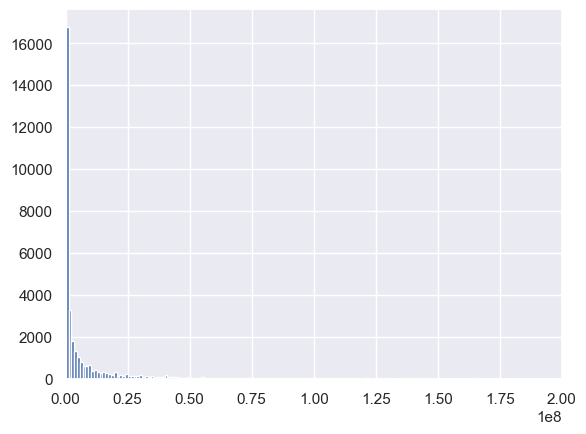

In [106]:
#Histogram of total funding aquired by the startups

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_org['funding_total_usd'], bins = 5000)
ax.set_xlim(left=0, right=200000000);

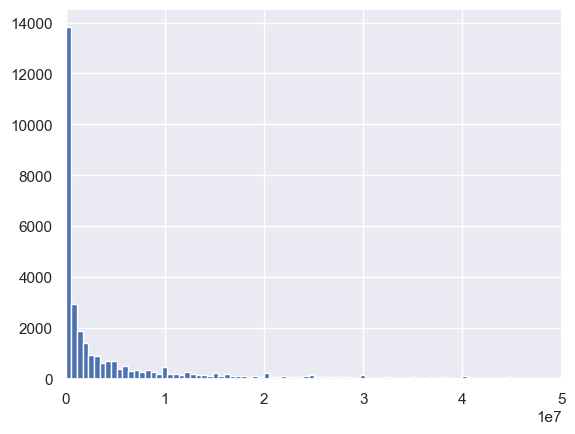

In [107]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_org['funding_total_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

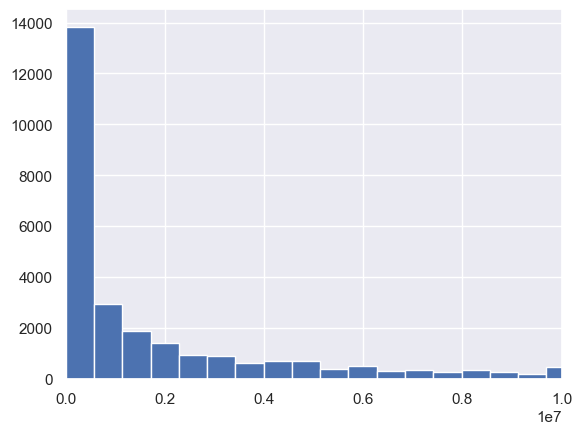

In [108]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 10000000 (10 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_org['funding_total_usd'], bins = 10000)
ax.set_xlim(left=0, right=10000000);

The distribution of the total funding aquired by the start-ups is highly positively skewed, with median 2.08 of million USD much lower than the mean value of 15.73 million USD. A significant 'long tail' can be observed, with startups receiving much more funding than the average - the maximal value of total funding received is equal to 5.7 bn USD. Most of the startups took part in one or two funding rounds.

#### Start-ups that aquired the most funding

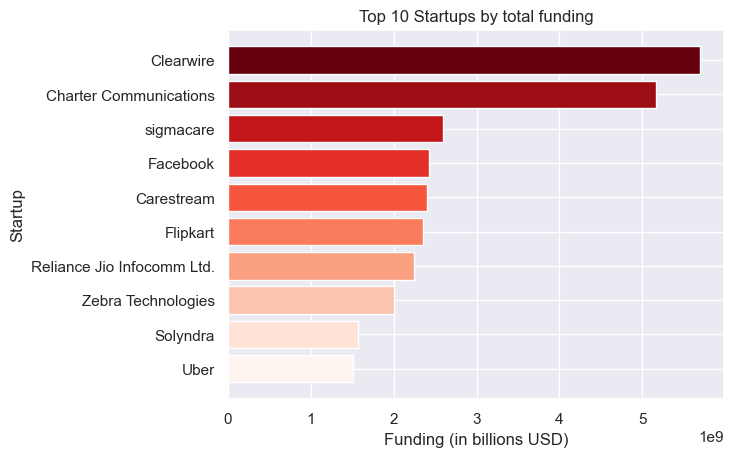

In [109]:
#Values of top 10 start-ups
top_10_startups = df_org.sort_values(by=['funding_total_usd'],ascending=False).head(10)
top_10_startups = top_10_startups.iloc[::-1]

#Create the bar plot
colors = plt.cm.get_cmap('Reds')(np.linspace(0, 1, len(top_10_startups)))
plt.barh(top_10_startups['name'], top_10_startups['funding_total_usd'], color=colors)
plt.xlabel('Funding (in billions USD)')
plt.ylabel('Startup')
plt.title('Top 10 Startups by total funding')
plt.show()

All the start-ups from the top 10 (in terms of total funding received) had raised funding exceeding 1 bn USD.

### 2.1.3 Status of the start-ups

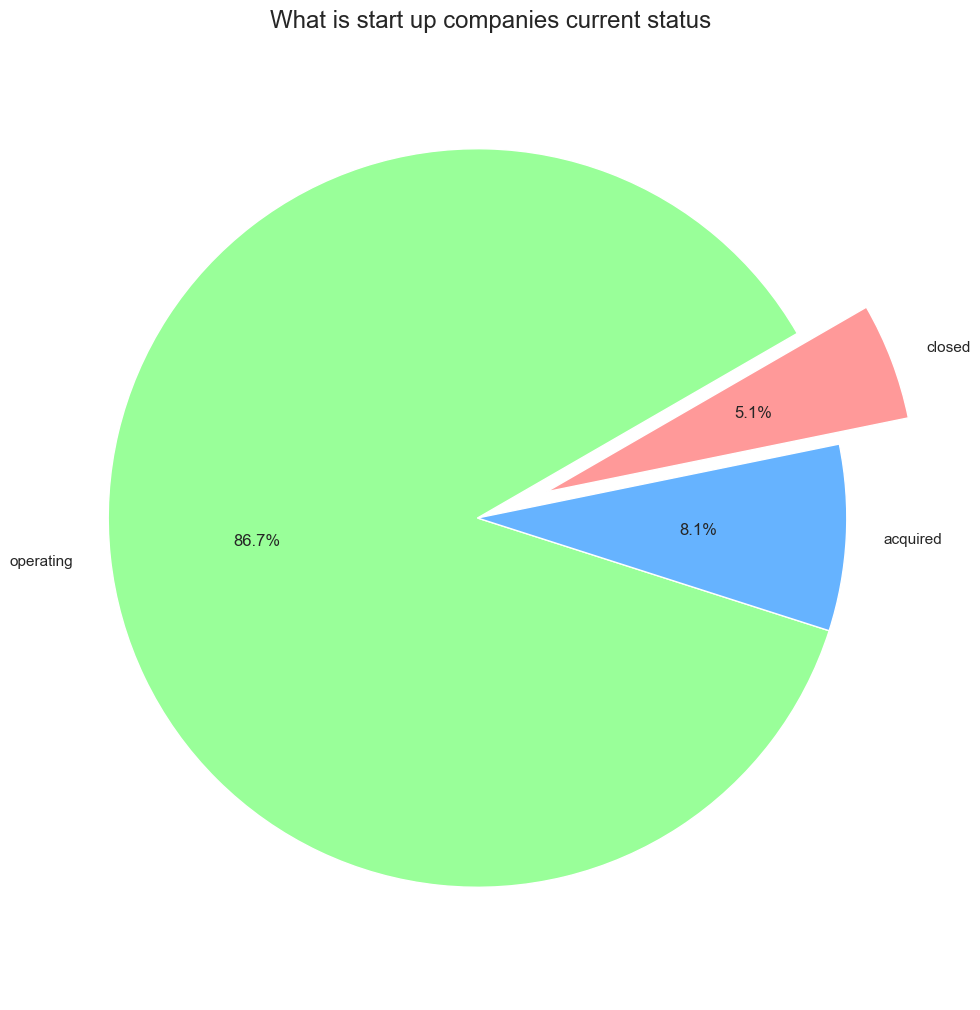

In [110]:
plt.rcParams['figure.figsize'] = 10,10
labels = df_org['status'].value_counts().index.tolist()
sizes = df_org['status'].value_counts().tolist()
explode = (0, 0, 0.2)
colors = ['#99ff99','#66b3ff','#ff9999']

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("What is start up companies current status", fontdict=None, position= [0.48,1], size = 'x-large')
plt.show()

It can be noted that the majority of start-ups are still operating (as for 2015), and more companies were acquired than suspended their operations.

### 2.1.4 The most common markets (industries)

In [111]:
len(df_org['market'].unique())

721

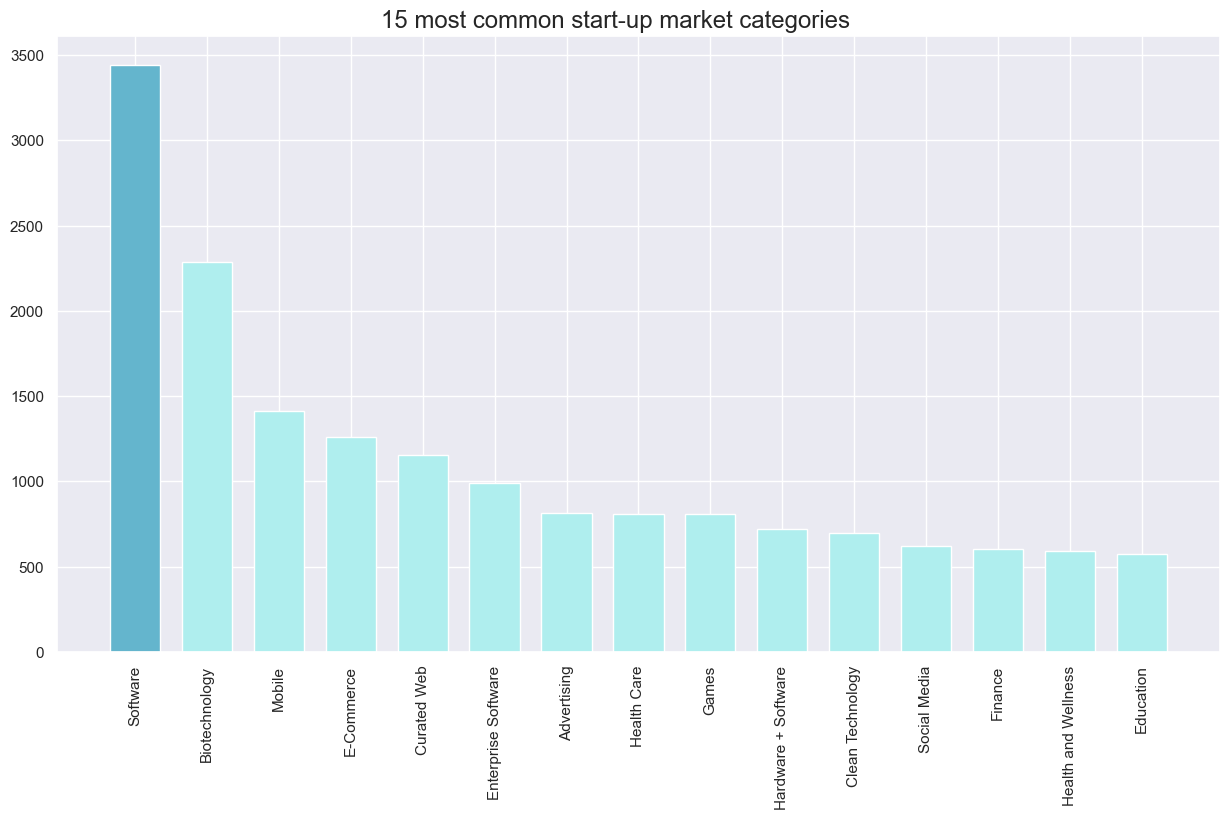

In [112]:
#Plot the 15 most common start-up market categories  
plt.rcParams['figure.figsize'] = 15,8
height = df_org['market'].value_counts()[:15].tolist()
bars =  df_org['market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("15 most common start-up market categories", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

In [113]:
df_org['count'] = 1
country_market = df_org[['count','country_code','market']].groupby(['country_code','market']).agg({'count': 'sum'})
country_market_pct = country_market.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
country_market_pct.reset_index(inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\217426570.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  country_market_pct = country_market.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


In [114]:
USA_market_pct = country_market_pct[country_market_pct['country_code'] == "USA"]
USA_market_pct = USA_market_pct.sort_values('count',ascending = False)[0:10]

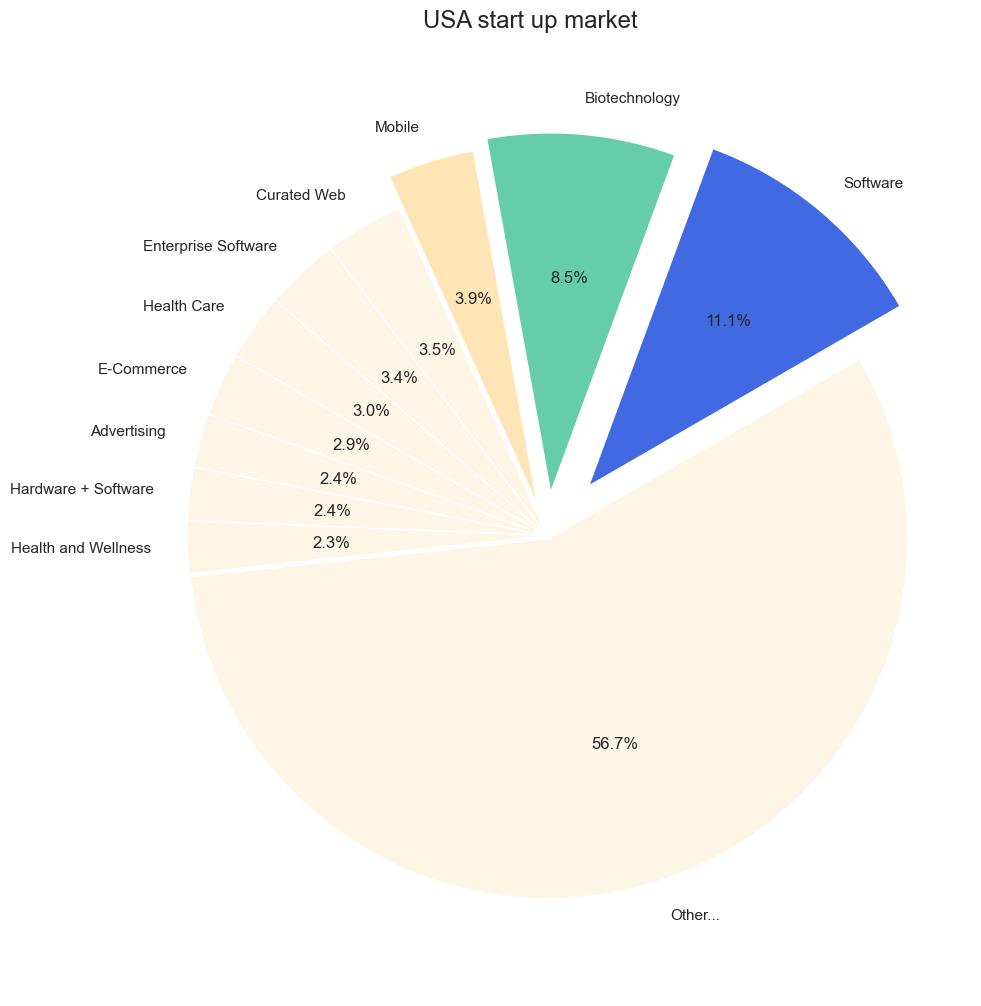

In [115]:
## Plot the breakdown of start-up market categories in the USA
plt.rcParams['figure.figsize'] =10,10
labels = list(USA_market_pct['market'])+['Other...']
sizes = list(USA_market_pct['count'])+[100-USA_market_pct['count'].sum()]
explode = (0.18, 0.12, 0.09,0,0,0,0,0,0,0,0.01)
colors =  ['royalblue','mediumaquamarine','moccasin'] +['oldlace']*8

plt.pie(sizes, explode = explode, colors = colors ,labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("USA start up market", fontdict=None, position= [0.48,1.1], size = 'x-large')

plt.show()


On the charts above, the most common market categories for the global market and the American market were provided. Most of the startups both globally and on the US market were operating on Software, Biotechnology and Mobile markets.

### 2.1.5 Total start-up funding compared to different benchmarks

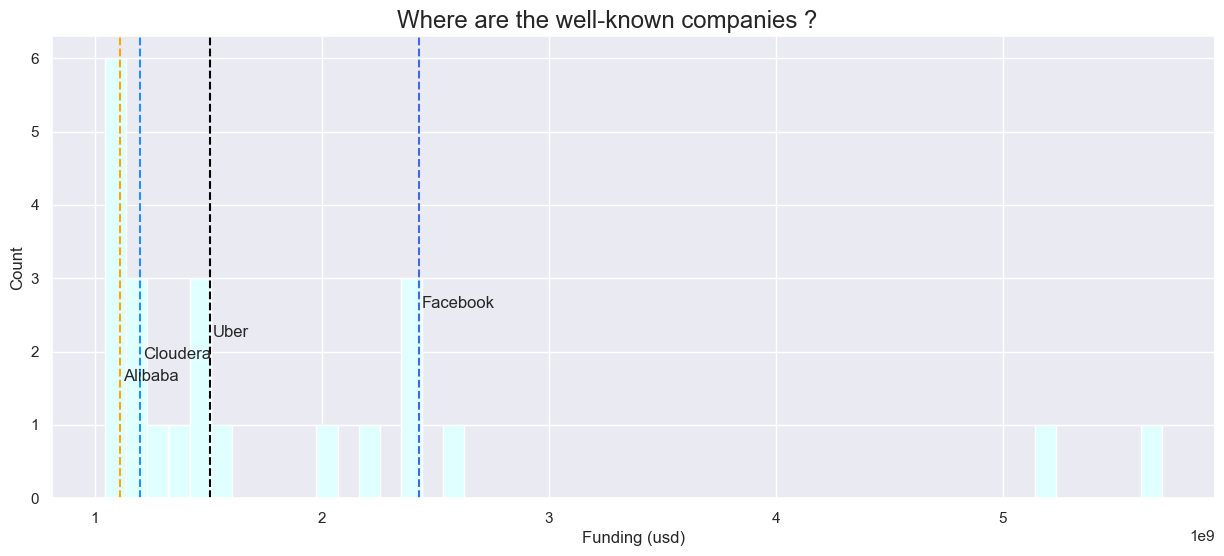

In [117]:
#Extract the total funding of the well-known companies 
Facebook_total_funding = df_org['funding_total_usd'][df_org['name']=="Facebook"].values[0]
Uber_total_funding = df_org['funding_total_usd'][df_org['name']=="Uber"].values[0]
Alibaba_total_funding = df_org['funding_total_usd'][df_org['name']=="Alibaba"].values[0]
Cloudera_total_funding = df_org['funding_total_usd'][df_org['name']=="Cloudera"].values[0]

plt.rcParams['figure.figsize'] = 15,6
plt.hist(df_org['funding_total_usd'][(df_org['funding_total_usd'] >= 1000000000)].dropna(), bins=50,color = 'lightcyan' )
plt.ylabel('Count')
plt.xlabel('Funding (usd)')
plt.title("Where are the well-known companies ? ", fontdict=None, position= [0.48,1.05], size = 'x-large')

#Add the values the well-known companies benchmarks
plt.axvline(Facebook_total_funding,color='royalblue',linestyle ="--")
plt.text(Facebook_total_funding+15000000, 2.6,"Facebook")

plt.axvline(Uber_total_funding,color='black',linestyle ="--")
plt.text(Uber_total_funding+10000000, 2.2,"Uber")

plt.axvline(Cloudera_total_funding,color='dodgerblue',linestyle ="--")
plt.text(Cloudera_total_funding+10000000, 1.9,"Cloudera")

plt.axvline(Alibaba_total_funding,color='orange',linestyle ="--")
plt.text(Alibaba_total_funding+10000000, 1.6,"Alibaba")


plt.show()

Among the companies that received more than 1 bn USD total funding, the chosen well-known companies are not the leaders.  Facebook which is in the top 5 of companies that received the most funding, and Uber closes the top 10.

In [118]:
#Change the type of 'founded_at' column
df_org['founded_at'] = pd.to_datetime(df_org['founded_at'])

### 2.1.6 When the companies were founded?

In [119]:
df_org['founded_at'] = pd.to_datetime(df_org['founded_at'], errors = 'coerce' )

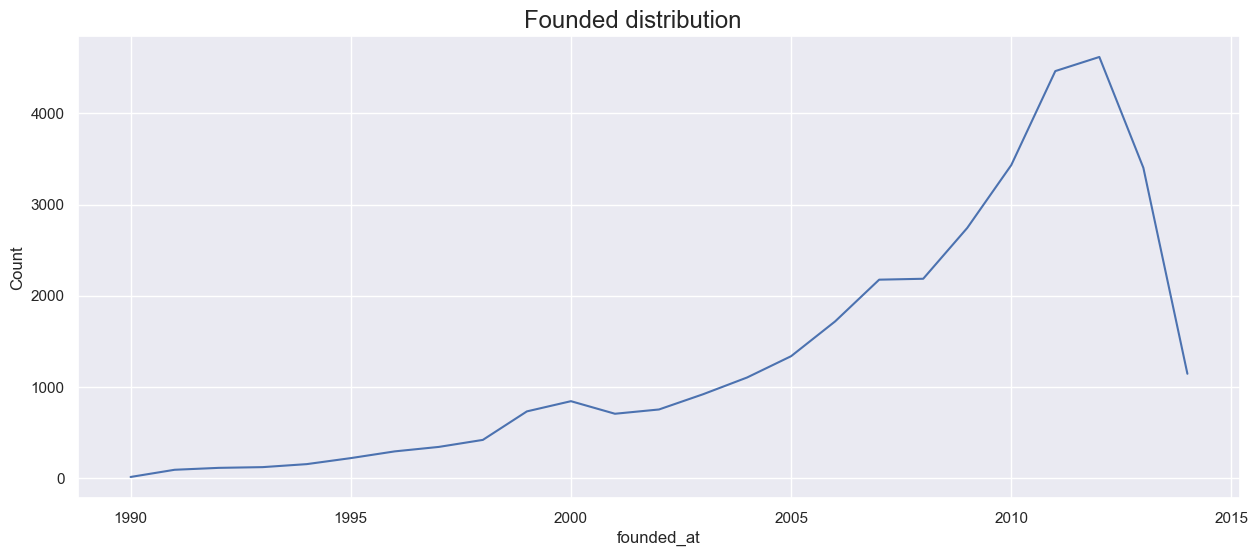

In [120]:
plt.rcParams['figure.figsize'] = 15,6
df_org['name'].groupby(df_org["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Founded distribution ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Number of star-ups funded was growing till early 2010s, when it reached a peak and drasticly declined. The most companies were founded in 2011 and 2012.

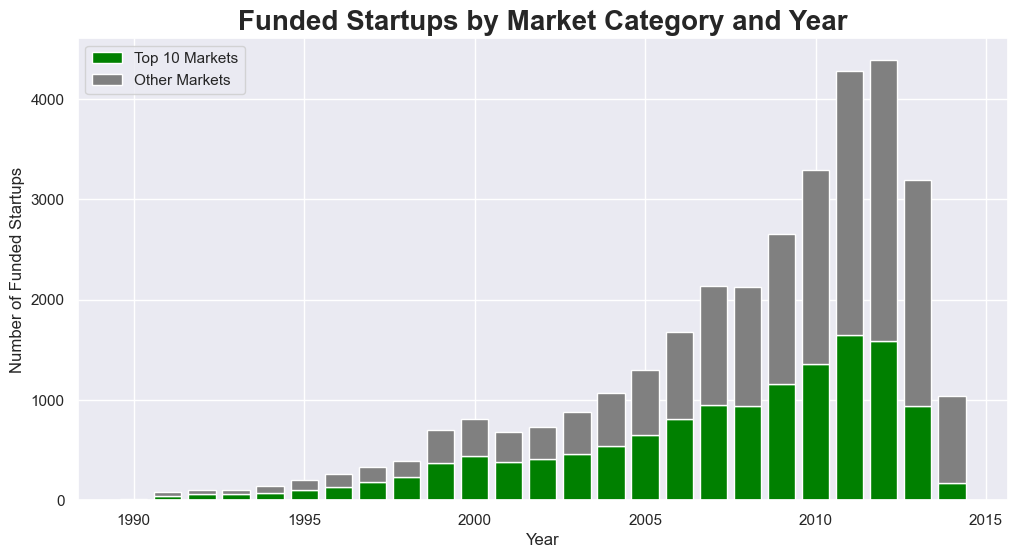

In [121]:

market_counts = df_org.groupby([df_org["founded_at"].dt.year, "market"])["name"].count().unstack(fill_value=0)
top_10_markets = market_counts.sum().nlargest(10).index.tolist()

#Additional column will represent categories outside the top 10, market as "other
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

top_10_counts = market_counts[top_10_markets].sum(axis=1)
other_counts = market_counts["Other"]

# Plot it as a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_10_counts.index, top_10_counts, color="green", label="Top 10 Markets")
ax.bar(other_counts.index, other_counts, bottom=top_10_counts, color="gray", label="Other Markets")

#Labels and formatting
ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")
ax.set_title("Funded Startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')
ax.legend()

plt.show()

It can be noted that the top 10 markets accound for a vast part of all start-ups count in a given year - in some years around to the half of all companies founded. 

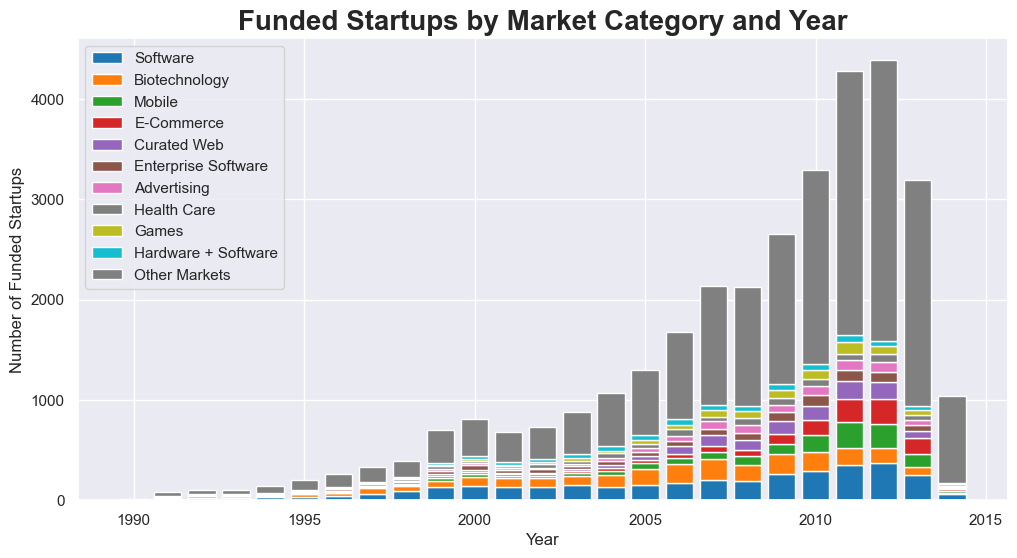

In [122]:
market_counts = df_org.groupby([df_org["founded_at"].dt.year, "market"])["name"].count().unstack(fill_value=0)

top_10_markets = market_counts.sum().nlargest(10).index.tolist()

for market in top_10_markets:
    market_counts[market] = market_counts[market] if market in market_counts.columns else 0
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

#Separate the top 10 market categories on the plot
market_colors = plt.get_cmap('tab10').colors
for i, market in enumerate(top_10_markets):
    ax.bar(market_counts.index, market_counts[market], bottom=market_counts[top_10_markets[:i]].sum(axis=1), color=market_colors[i], label=market)
ax.bar(market_counts.index, market_counts["Other"], bottom=market_counts[top_10_markets].sum(axis=1), color="gray", label="Other Markets")

# Labels and formatting
ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")

ax.set_title("Funded Startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')

ax.legend()

plt.show()


By breaking down the top 10 industries, it can be observed that the share of Software and Biotechnology market has been very significant from late 1990's until 2014. From around 2005 till 2014 the number of start-ups founded and oriented on Mobile market has increased dynamicly. 

#### How many companies were founded yearly given the economic events

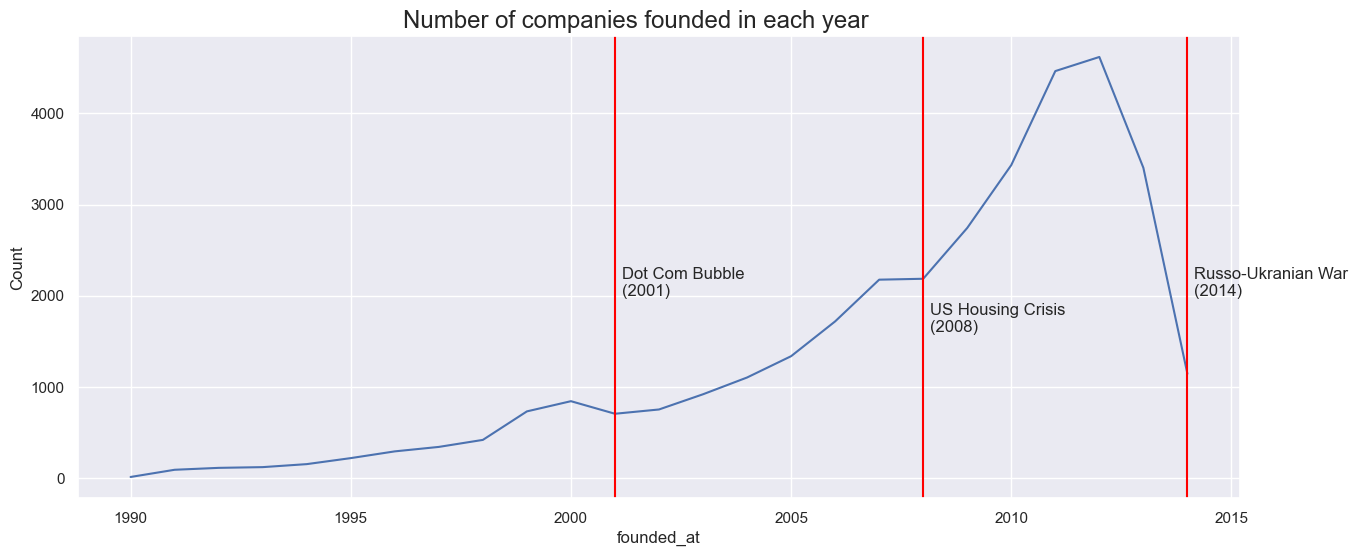

In [123]:
plt.rcParams['figure.figsize'] = 15,6
df_org['name'].groupby(df_org["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Number of companies founded in each year", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.axvline(2008,color='red')
plt.text(2008+0.15, 1600,"US Housing Crisis \n(2008)")
plt.axvline(2001,color='red')
plt.text(2001+0.15, 2000,"Dot Com Bubble \n(2001)")

plt.axvline(2014,color='red')
plt.text(2014+0.15, 2000,"Russo-Ukranian War \n(2014)")
plt.show()

As can be observed, all of the decline in number of start-ups founded happened at the same time as major global crises.

In [124]:
Facebook_founded_year = df_org['founded_at'][df_org['name']=="Facebook"].dt.year.values[0]
Uber_founded_year  = df_org['founded_at'][df_org['name']=="Uber"].dt.year.values[0]
Alibaba_founded_year  = df_org['founded_at'][df_org['name']=="Alibaba"].dt.year.values[0]

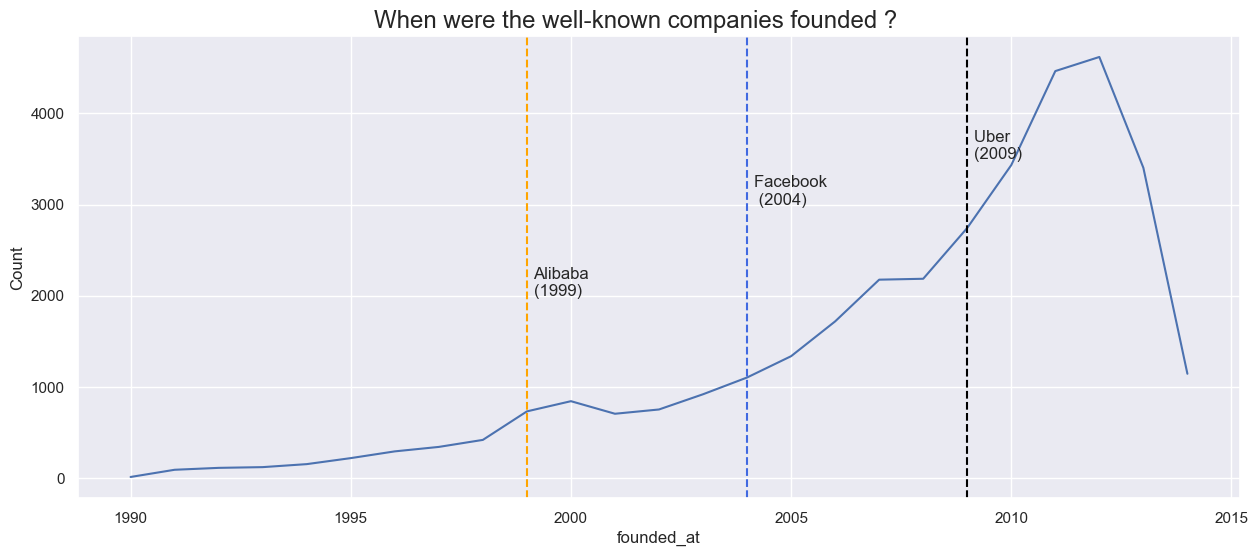

In [125]:
plt.rcParams['figure.figsize'] = 15,6
df_org['name'][df_org["founded_at"].dt.year >= 1990].groupby(df_org["founded_at"].dt.year).count().plot(kind="line")
plt.ylabel('Count')

plt.axvline(Facebook_founded_year,color='royalblue',linestyle ="--")
plt.text(Facebook_founded_year+0.15, 3000,"Facebook \n (2004)")

plt.axvline(Uber_founded_year,color='black',linestyle ="--")
plt.text(Uber_founded_year+0.15, 3500,"Uber \n(2009)")

plt.axvline(Alibaba_founded_year,color='orange',linestyle ="--")
plt.text(Alibaba_founded_year+0.15, 2000,"Alibaba \n(1999)")


plt.title("When were the well-known companies founded ?", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

### 2.1.7 Analysis of funding distribution grouped on yearly basis

In [126]:
df_org.groupby(df_org["founded_at"].dt.year)["funding_total_usd"].sum()

founded_at
1990      187836500
1991     3995324124
1992     2623861349
1993     7531214745
1994     2829948230
1995     5627878754
1996     6641906925
1997     7821029145
1998    11353475400
1999    19204130287
2000    19842393756
2001    20160886123
2002    19822435642
2003    27482346165
2004    34841356007
2005    36751155719
2006    35511892905
2007    48433091665
2008    29566564139
2009    30464863928
2010    27083863935
2011    24244516830
2012    18542307676
2013     8317518888
2014     1621189232
Name: funding_total_usd, dtype: int64

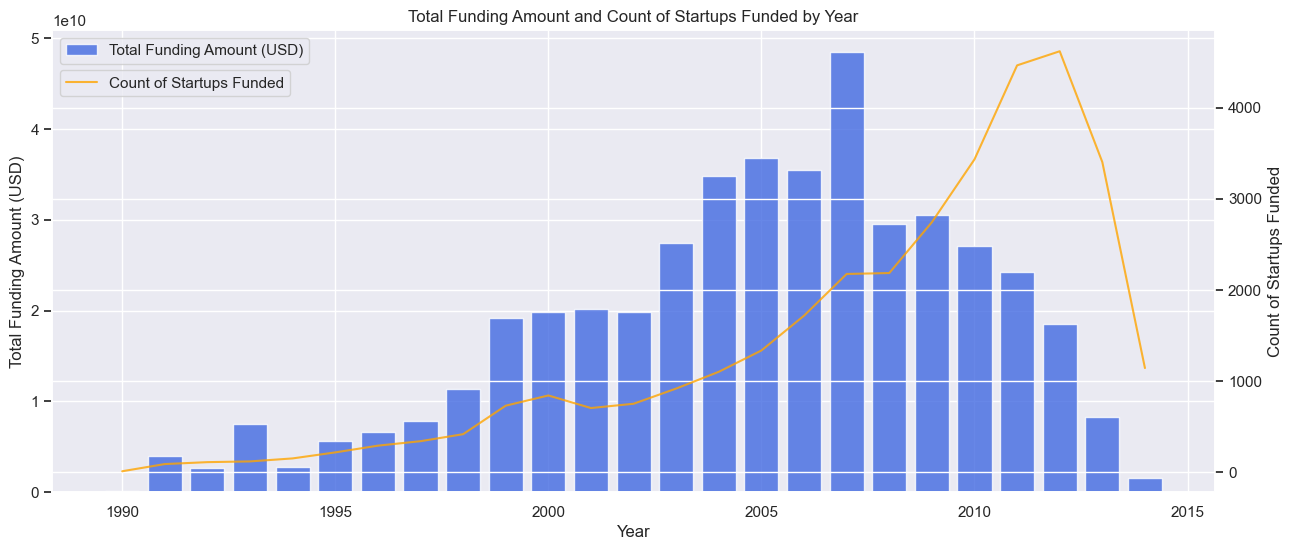

In [127]:
#Group by year
funding_by_year = df_org.groupby(df_org["founded_at"].dt.year)["funding_total_usd"].sum()
count_by_year = df_org.groupby(df_org["founded_at"].dt.year)["name"].count()
fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

#Create a bar chart 
ax1.bar(funding_by_year.index, funding_by_year.values, color='royalblue', alpha=0.8)

#Labels and formatting
ax1.set_ylabel('Total Funding Amount (USD)')
ax2.plot(count_by_year.index, count_by_year.values, color='orange', alpha=0.8)
ax2.set_ylabel('Count of Startups Funded')
ax1.set_title('Total Funding Amount and Count of Startups Funded by Year')
ax1.set_xlabel('Year')
ax1.legend(['Total Funding Amount (USD)'], loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(['Count of Startups Funded'], loc='upper left', bbox_to_anchor=(0, 0.93))
plt.show()

It can be observed that the increase and decrease trends in the total amount of funding and count of start-ups go hand-in-hand. However, there seems to be a slight lagging in which the increase in total funding, is followed by an increase in the count a couple of years later. For example, the total funding reached its peak in 2007 whereas the count reached its peak in 2012.

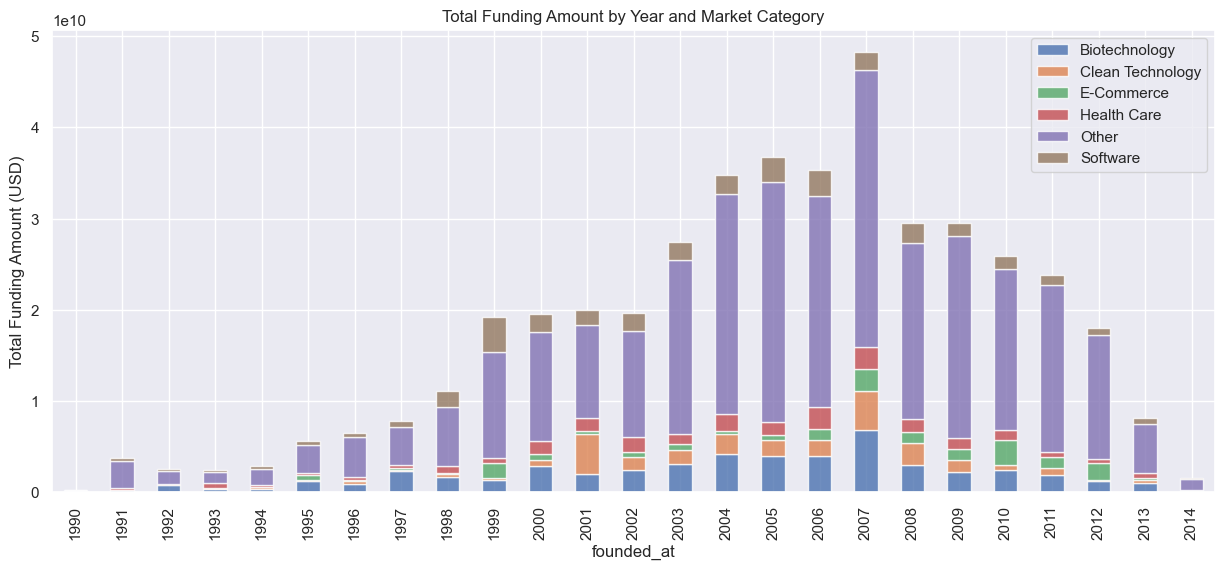

In [128]:
top_markets = df_org.groupby('market')['funding_total_usd'].sum().nlargest(5).index.tolist()
df_funding_by_year = df_org.groupby([df_org['founded_at'].dt.year, 'market'])['funding_total_usd'].sum().reset_index()
df_funding_by_year.loc[~df_funding_by_year['market'].isin(top_markets), 'market'] = 'Other'
df_funding_by_year = df_funding_by_year.groupby(['founded_at', 'market'])['funding_total_usd'].sum().unstack()
fig, ax = plt.subplots(figsize=(15,6))

# Plot it
df_funding_by_year.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)
ax.set_ylabel('Total Funding Amount (USD)')

# Labels and formatiing
ax.set_title('Total Funding Amount by Year and Market Category')
ax.legend()
plt.show()


In [129]:
# Top invested categories, can be compared with the graph above including the total number of startups
df_org.groupby('market').sum()['funding_total_usd'].sort_values(ascending=False).head()

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\3823176633.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_org.groupby('market').sum()['funding_total_usd'].sort_values(ascending=False).head()


market
Biotechnology       49762684997
Software            32981155808
Clean Technology    25184774891
Health Care         22138059269
E-Commerce          18013465979
Name: funding_total_usd, dtype: int64

### Funding by country analyses

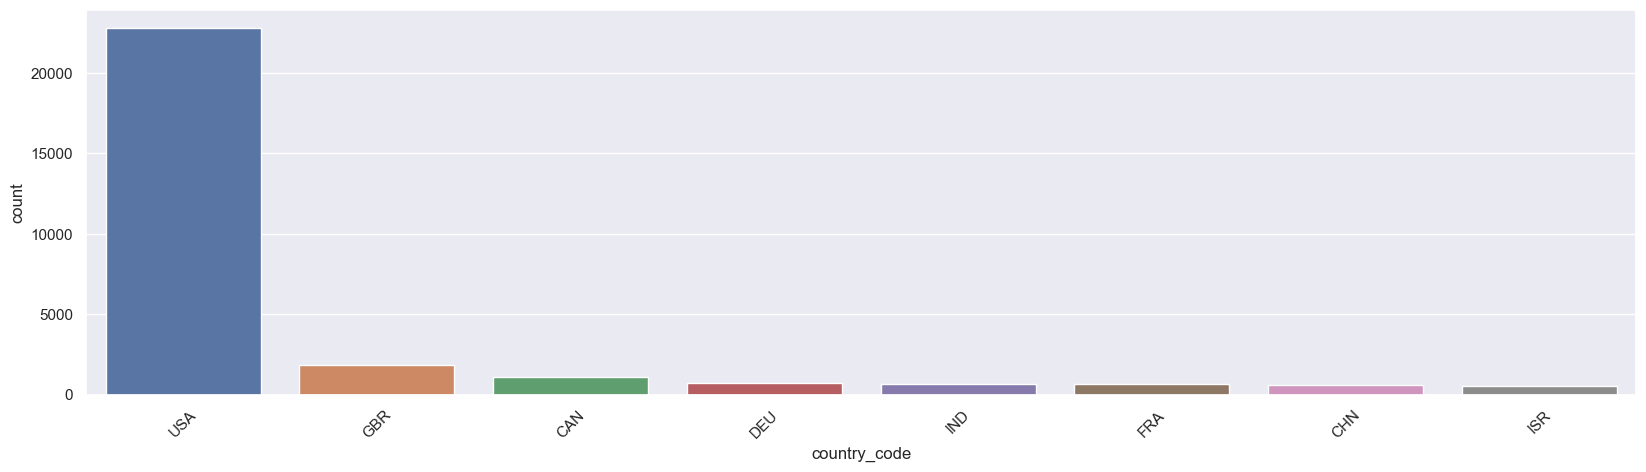

In [130]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='country_code', data = df_org, order=df_org['country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

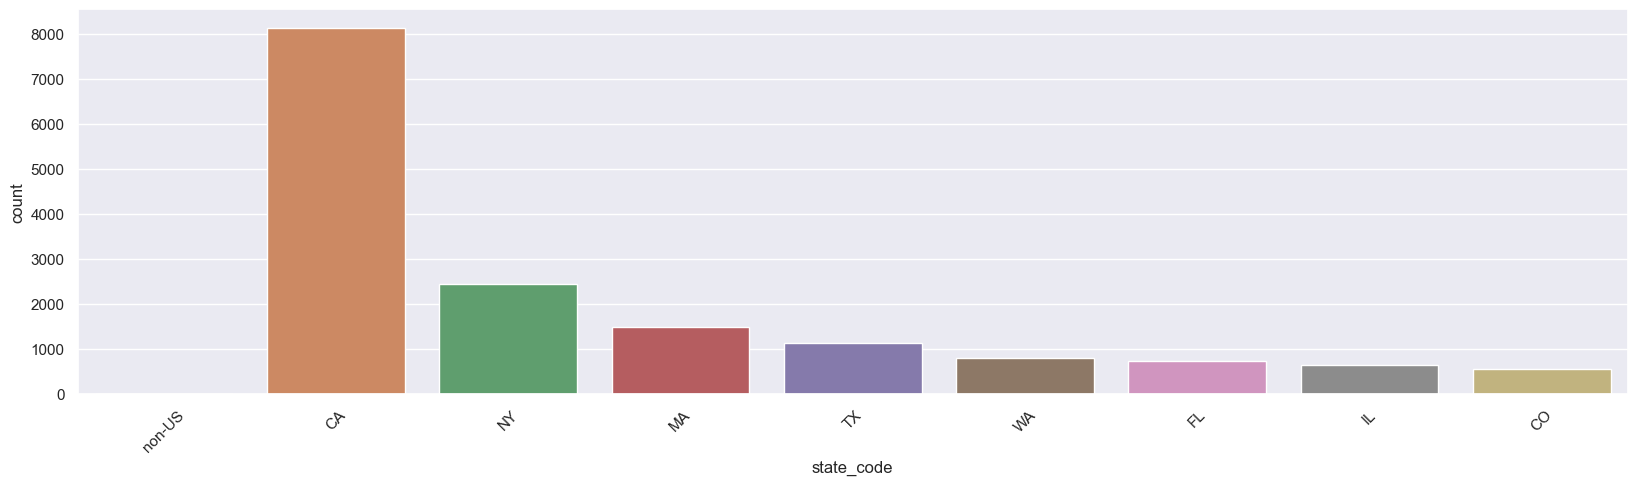

In [131]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='state_code', data = df_org[(df_org['country_code'] =='USA')], order=df_org['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()

The US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.    

## 2.2 Rounds

In [132]:
df_rd.head(10)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,06,Q2,2012.0,1750000.0
1,/organization/tv-communications,&TV Communications,|Games|,Games,USA,CA,Los Angeles,Los Angeles,/funding-round/59a3669a64e39360c2b939300bcda162,venture,NaN,2010-09-23,09,Q3,2010.0,3000000.0
2,/organization/tv-communications,&TV Communications,|Games|,Games,USA,CA,Los Angeles,Los Angeles,/funding-round/86d22afc65107b6941e6c43c671ecbb8,venture,NaN,2010-06-04,06,Q2,2010.0,1000000.0
3,/organization/rock-your-paper,'Rock' Your Paper,|Publishing|Education|,Publishing,EST,NaN,Tallinn,Tallinn,/funding-round/f06b420775f7cb6c1541a9db526534bb,seed,NaN,2012-08-09,08,Q3,2012.0,40000.0
4,/organization/in-touch-network,(In)Touch Network,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,GBR,NaN,London,London,/funding-round/33c3f135f05d7b734b8d7b7c8ae82647,seed,NaN,2011-04-01,04,Q2,2011.0,1500000.0
5,/organization/r-ranch-and-mine,-R- Ranch and Mine,|Tourism|Entertainment|Games|,Tourism,USA,TX,Dallas,Fort Worth,/funding-round/029720f7eeb218f51c43df5155671472,equity_crowdfunding,NaN,2014-08-17,08,Q3,2014.0,10000.0
6,/organization/r-ranch-and-mine,-R- Ranch and Mine,|Tourism|Entertainment|Games|,Tourism,USA,TX,Dallas,Fort Worth,/funding-round/766b0bcead9ca8560af5e1ade579fb7f,equity_crowdfunding,NaN,2014-09-26,09,Q3,2014.0,50000.0
7,/organization/club-domains,.Club Domains,|Software|,Software,USA,FL,Ft. Lauderdale,Oakland Park,/funding-round/aee671c9707f8278a9544c8ae37650e0,venture,B,2013-05-31,05,Q2,2013.0,7000000.0
8,/organization/fox-networks,.Fox Networks,|Advertising|,Advertising,ARG,NaN,Buenos Aires,Buenos Aires,/funding-round/69a1536a6f4506538afd7aa7241ddbe1,undisclosed,NaN,2007-01-16,01,Q1,2007.0,4912393.0
9,/organization/0-6-com,0-6.com,|Curated Web|,Curated Web,NaN,NaN,NaN,NaN,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,03,Q1,2008.0,2000000.0


### 2.2.1 Descriptive statistics

Compared to the organisations data frame, the variable 'raised_amount_usd' has got lower mean. The observation count is higher by around 2.5 times compared to organisations data frame. The standard devation is around 25% higher than for the organisations data frame. The median is slighly lower, while the maximal value is around 2 times higher.

In [133]:
df_rd.describe()

,funded_year,raised_amount_usd
count,83821.000000,7.102200e+04
mean,2011.032080,9.162906e+06
std,2.804351,9.658191e+07
min,1990.000000,0.000000e+00
25%,2010.000000,3.544675e+05
50%,2012.000000,1.700000e+06
75%,2013.000000,6.515628e+06
max,2015.000000,2.127194e+10


### 2.2.2 Funding aquired by the startups

The distribution of funding raised in a given round is a bit more skewed than the distribution of the toal funding, but the pattern is similar -  similar to a negative exponential distribution.

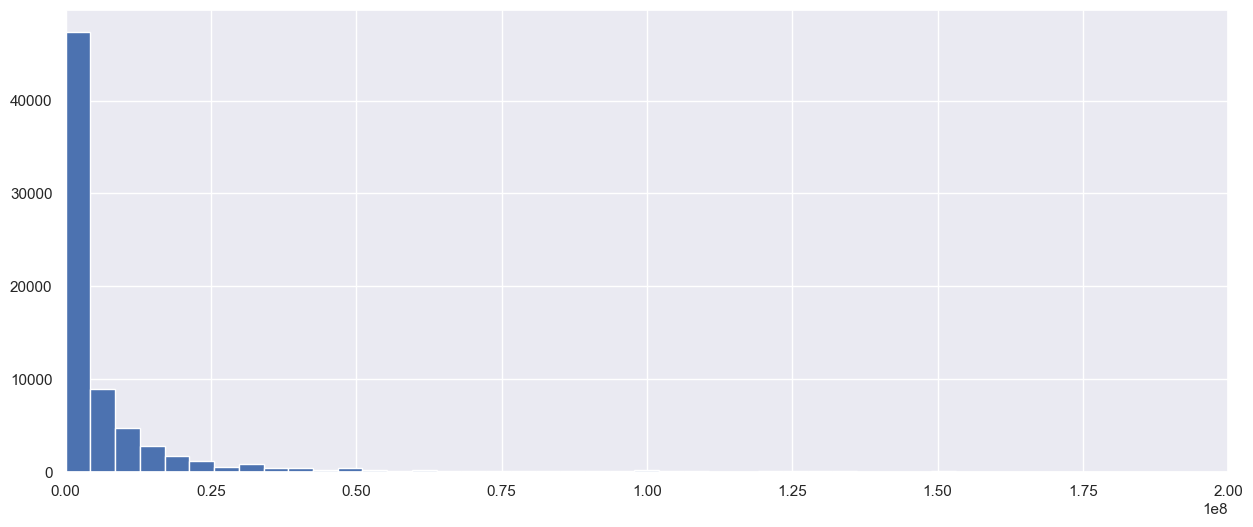

In [134]:
#Similar histogram as for organisations

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_rd['raised_amount_usd'], bins = 5000)
ax.set_xlim(left=0, right=200000000);

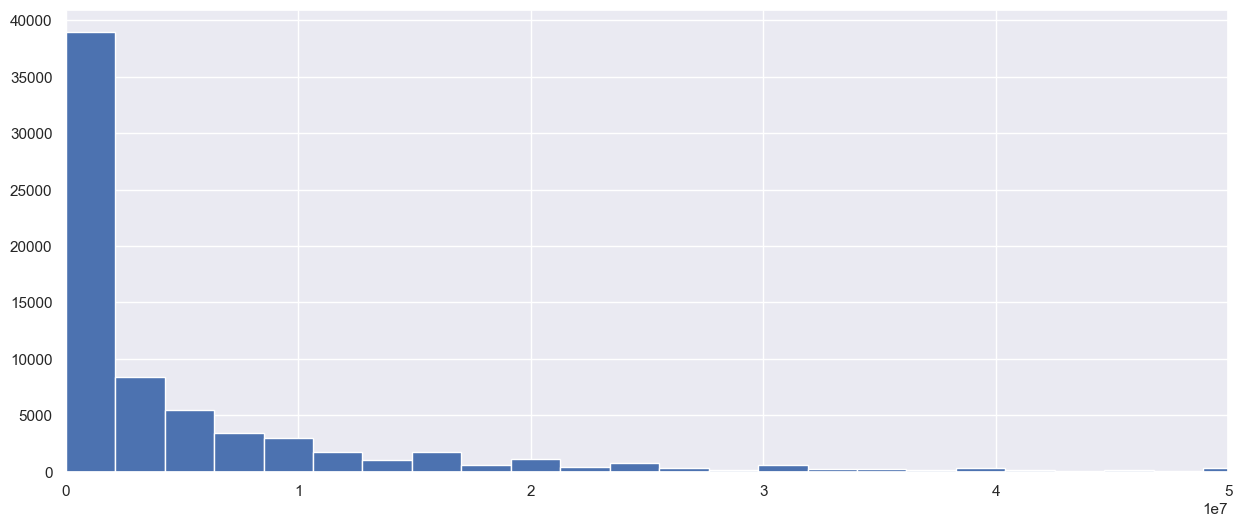

In [135]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_rd['raised_amount_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

#### Start-ups that aquired the most funding

Verizon Communications, Sberbank and Chaler Communications received the most 

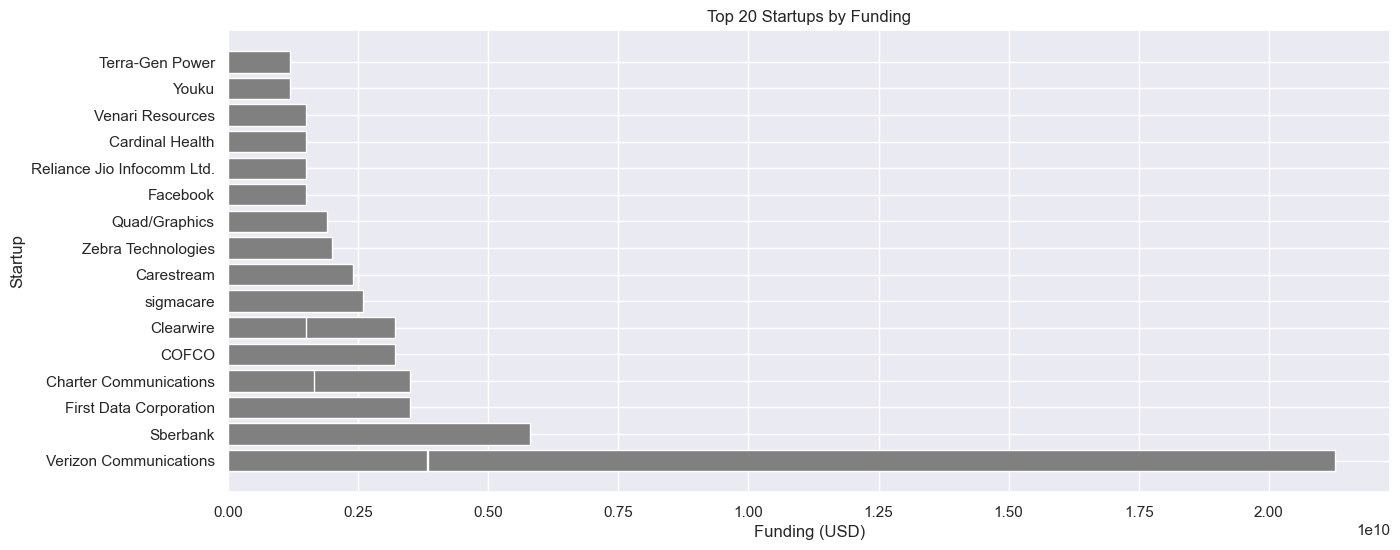

In [136]:
# sort the data 
top = df_rd.sort_values(by=['raised_amount_usd'],ascending=False).head(20)

# Bar plot - horizontal
plt.barh(top['company_name'], top['raised_amount_usd'], color='grey')
plt.xlabel('Funding (USD)')
plt.ylabel('Startup')
plt.title('Top 20 Startups by Funding')
plt.show()

### 2.2.3 The most common markets (industries)

In [137]:
len(df_rd['company_market'].unique())

754

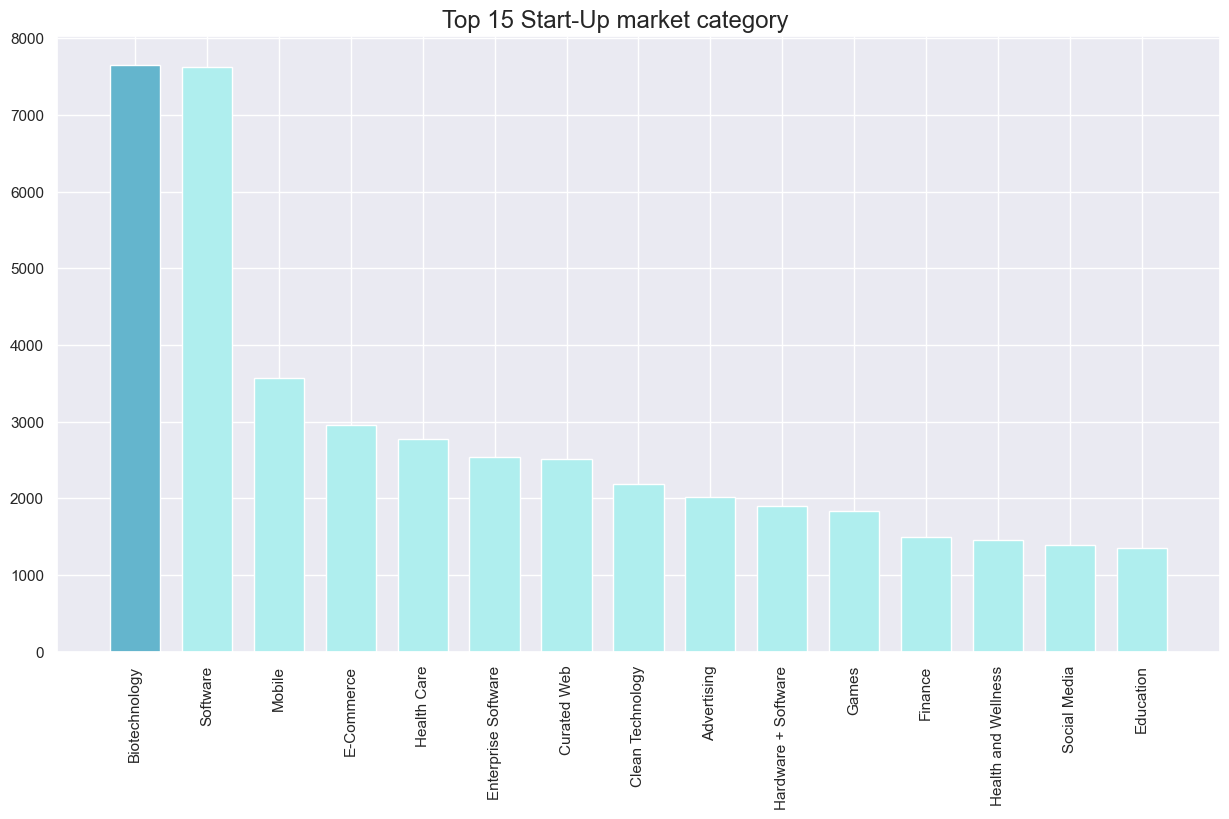

In [138]:
plt.rcParams['figure.figsize'] = 15,8

height = df_rd['company_market'].value_counts()[:15].tolist()
bars =  df_rd['company_market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up market category", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Compared to the total funding aquired, the biotechnology has got more funding than software. There are also other differences in the top categories. The values for each category are higher than in case of the organisation data frame.

In [139]:
df_rd['count'] = 1
country_market = df_rd[['count','company_country_code','company_market']].groupby(['company_country_code','company_market']).agg({'count': 'sum'})
# Change: groupby state_office and divide by sum
country_market_pct = country_market.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
country_market_pct.reset_index(inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\65608281.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  country_market_pct = country_market.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


In [140]:
USA_market_pct = country_market_pct[country_market_pct['company_country_code'] == "USA"]
USA_market_pct = USA_market_pct.sort_values('count',ascending = False)[0:10]

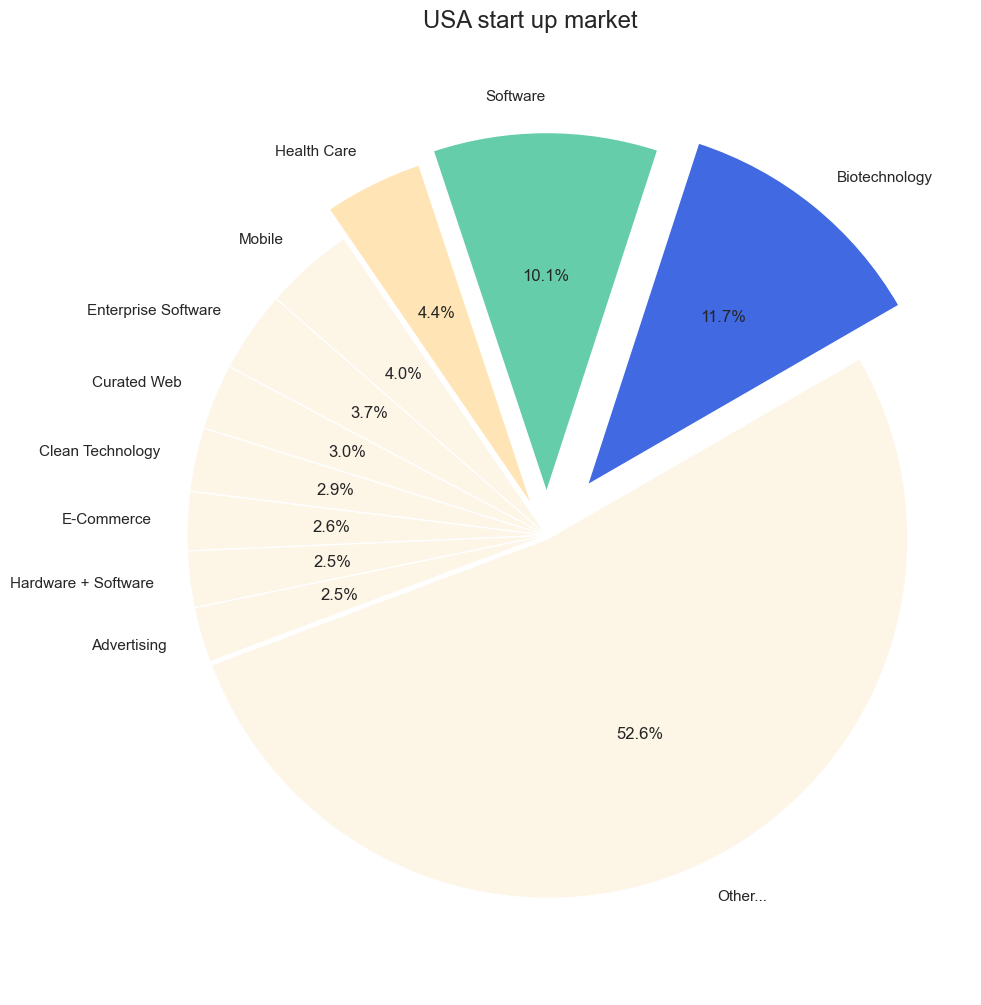

In [141]:
## USA
plt.rcParams['figure.figsize'] =10,10
labels = list(USA_market_pct['company_market'])+['Other...']
sizes = list(USA_market_pct['count'])+[100-USA_market_pct['count'].sum()]
explode = (0.18, 0.12, 0.09,0,0,0,0,0,0,0,0.01)
colors =  ['royalblue','mediumaquamarine','moccasin'] +['oldlace']*8

plt.pie(sizes, explode = explode, colors = colors ,labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("USA start up market", fontdict=None, position= [0.48,1.1], size = 'x-large')

plt.show()


The breakdown of funding on the American market leads to similar conclusions as the previous chart, presenting the worldwide breakdown of funding. Compared to the part 2.1, the biotechnology has got a higher share than software, the organisations' data inidcated the opposite. Also Health Care is on 3rd place, whilst it was on 6th position at the respective chart made on basis of the organisations data.    

### 2.2.4 Number of rounds by year and funding

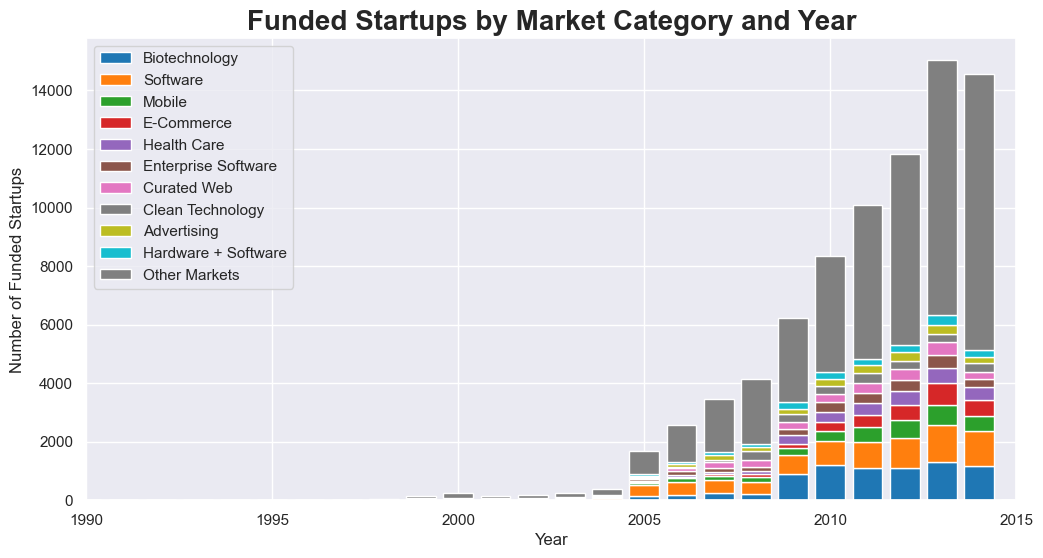

In [142]:

market_counts = df_rd.groupby([df_rd["funded_year"], "company_market"])["company_name"].count().unstack(fill_value=0)
top_10_markets = market_counts.sum().nlargest(10).index.tolist()

for market in top_10_markets:
    market_counts[market] = market_counts[market] if market in market_counts.columns else 0
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

market_colors = plt.get_cmap('tab10').colors
for i, market in enumerate(top_10_markets):
    ax.bar(market_counts.index, market_counts[market], bottom=market_counts[top_10_markets[:i]].sum(axis=1), color=market_colors[i], label=market)
ax.bar(market_counts.index, market_counts["Other"], bottom=market_counts[top_10_markets].sum(axis=1), color="gray", label="Other Markets")


ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")

ax.set_title("Funded Startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')
ax.set_xlim(left=1990)
ax.set_xlim(right=2015)

ax.legend()

plt.show()


Similar to the part 2.1, the Biotechnology, Software and Mobile are the main start-up markets. 

In [143]:
df_rd.groupby('company_market').sum()['raised_amount_usd'].sort_values(ascending=False).head()

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\3741367596.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rd.groupby('company_market').sum()['raised_amount_usd'].sort_values(ascending=False).head()


company_market
Biotechnology       7.337290e+10
Mobile              4.947001e+10
Software            4.222412e+10
Clean Technology    3.761994e+10
Health Care         2.946608e+10
Name: raised_amount_usd, dtype: float64

### 2.2.5 Country Analyses

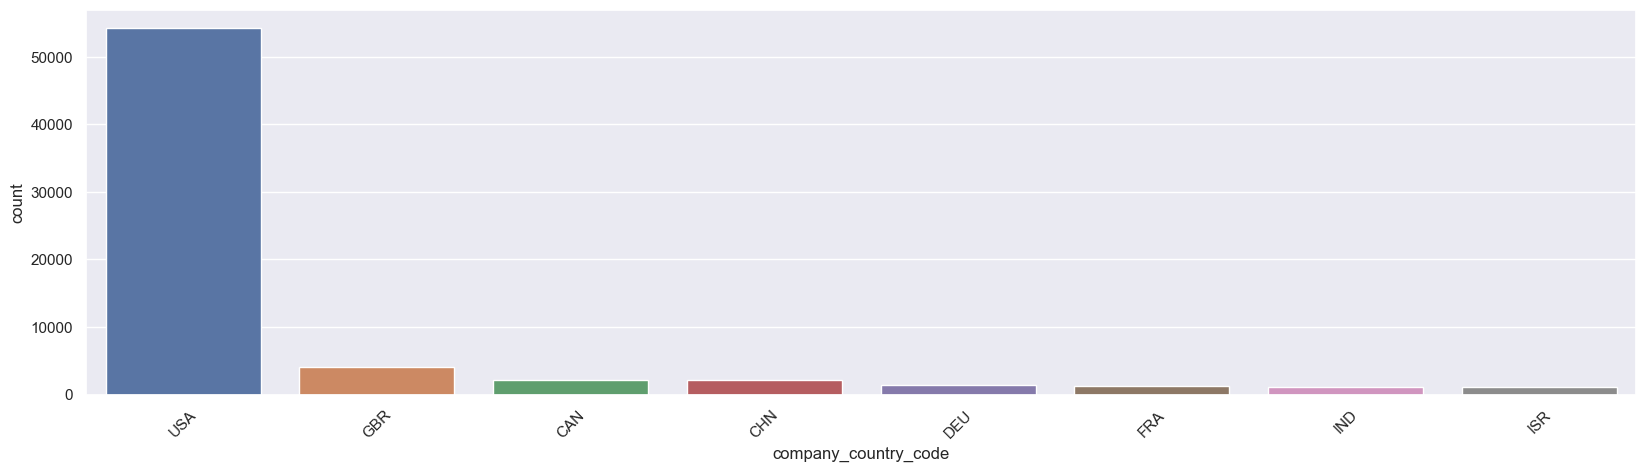

In [144]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='company_country_code', data = df_rd, order=df_rd['company_country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()


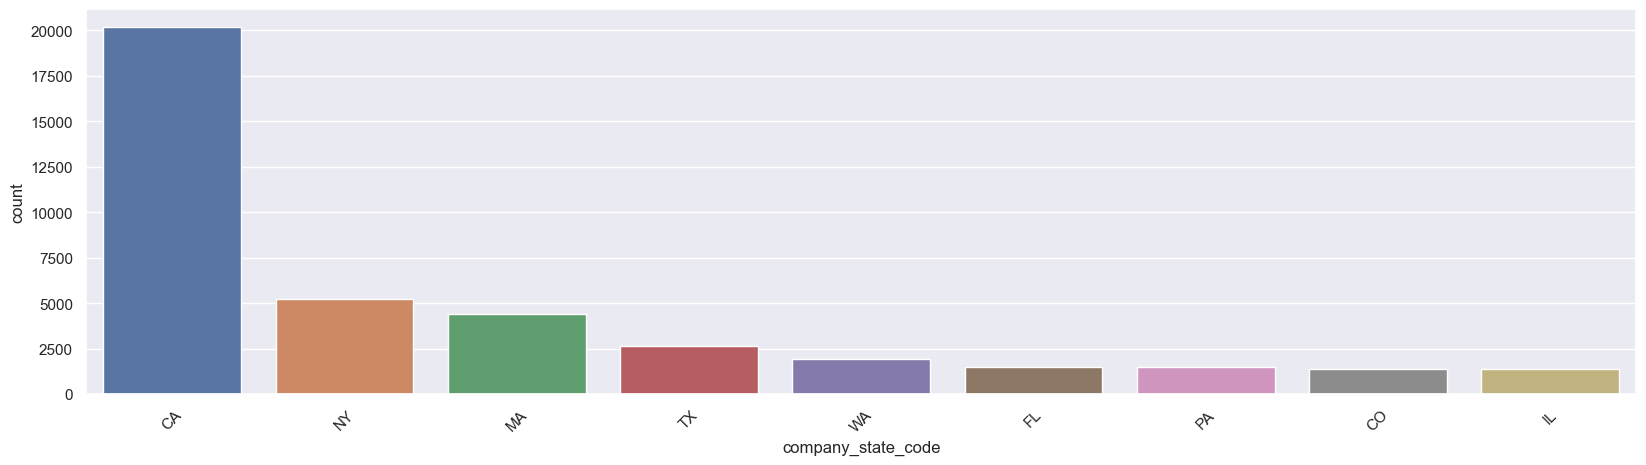

In [145]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='company_state_code', data = df_rd[(df_rd['company_country_code'] =='USA')], order=df_rd['company_state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()


Similar to part 2.1, the US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.    

### 2.2.6 Funds raised depending on the round code and type

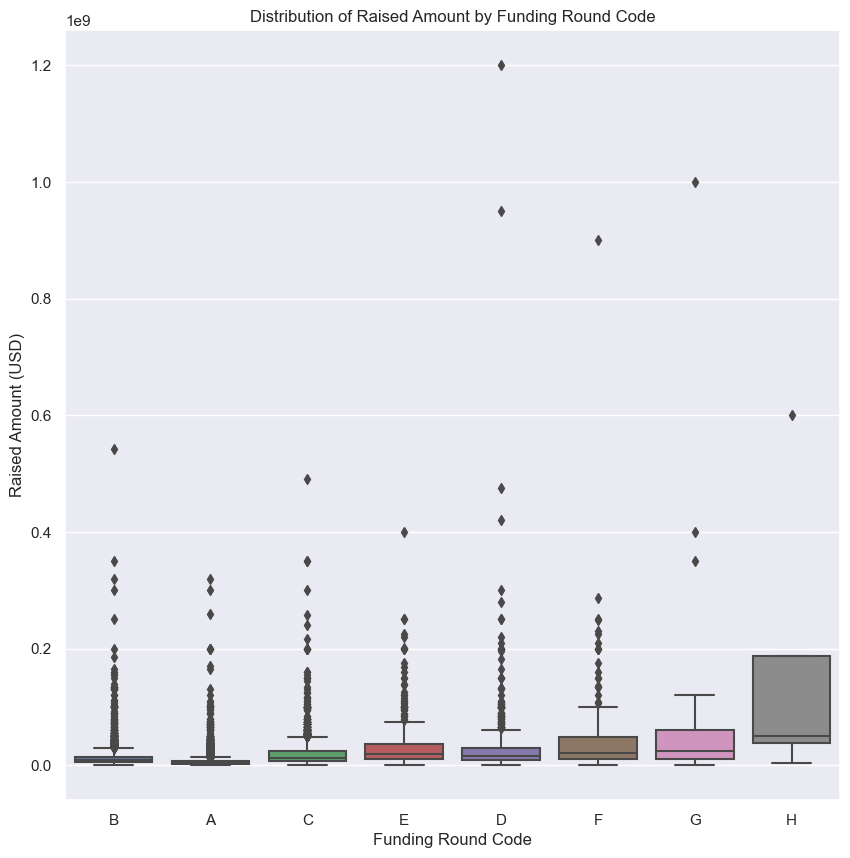

In [146]:
sns.boxplot(x='funding_round_code', y='raised_amount_usd', data=df_rd)

plt.xlabel('Funding Round Code')
plt.ylabel('Raised Amount (USD)')
plt.title('Distribution of Raised Amount by Funding Round Code')
plt.show()

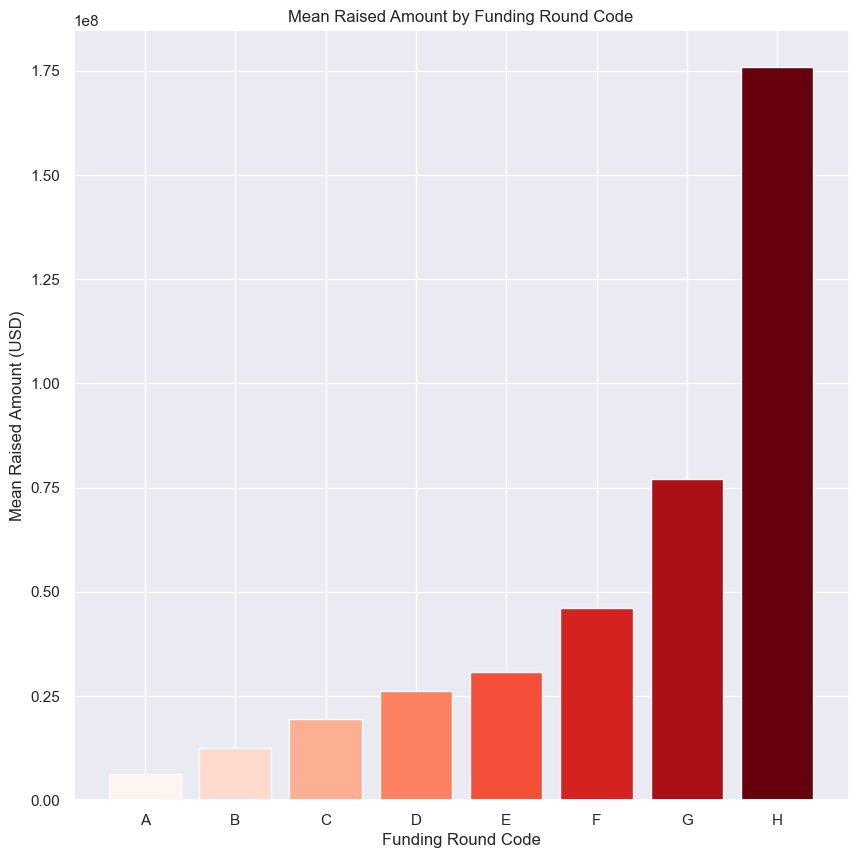

In [147]:
#Group the data
grouped = df_rd.groupby('funding_round_code')['raised_amount_usd'].mean().reset_index()

##Create the plot
colors = plt.cm.Reds(np.linspace(0, 1, len(grouped)))
plt.bar(grouped['funding_round_code'], grouped['raised_amount_usd'], color=colors)

# Labels and formatting
plt.xlabel('Funding Round Code')
plt.ylabel('Mean Raised Amount (USD)')
plt.title('Mean Raised Amount by Funding Round Code')
plt.show()

The mean raised amount has grown exponentially from round A to round H.

#### Funding round types

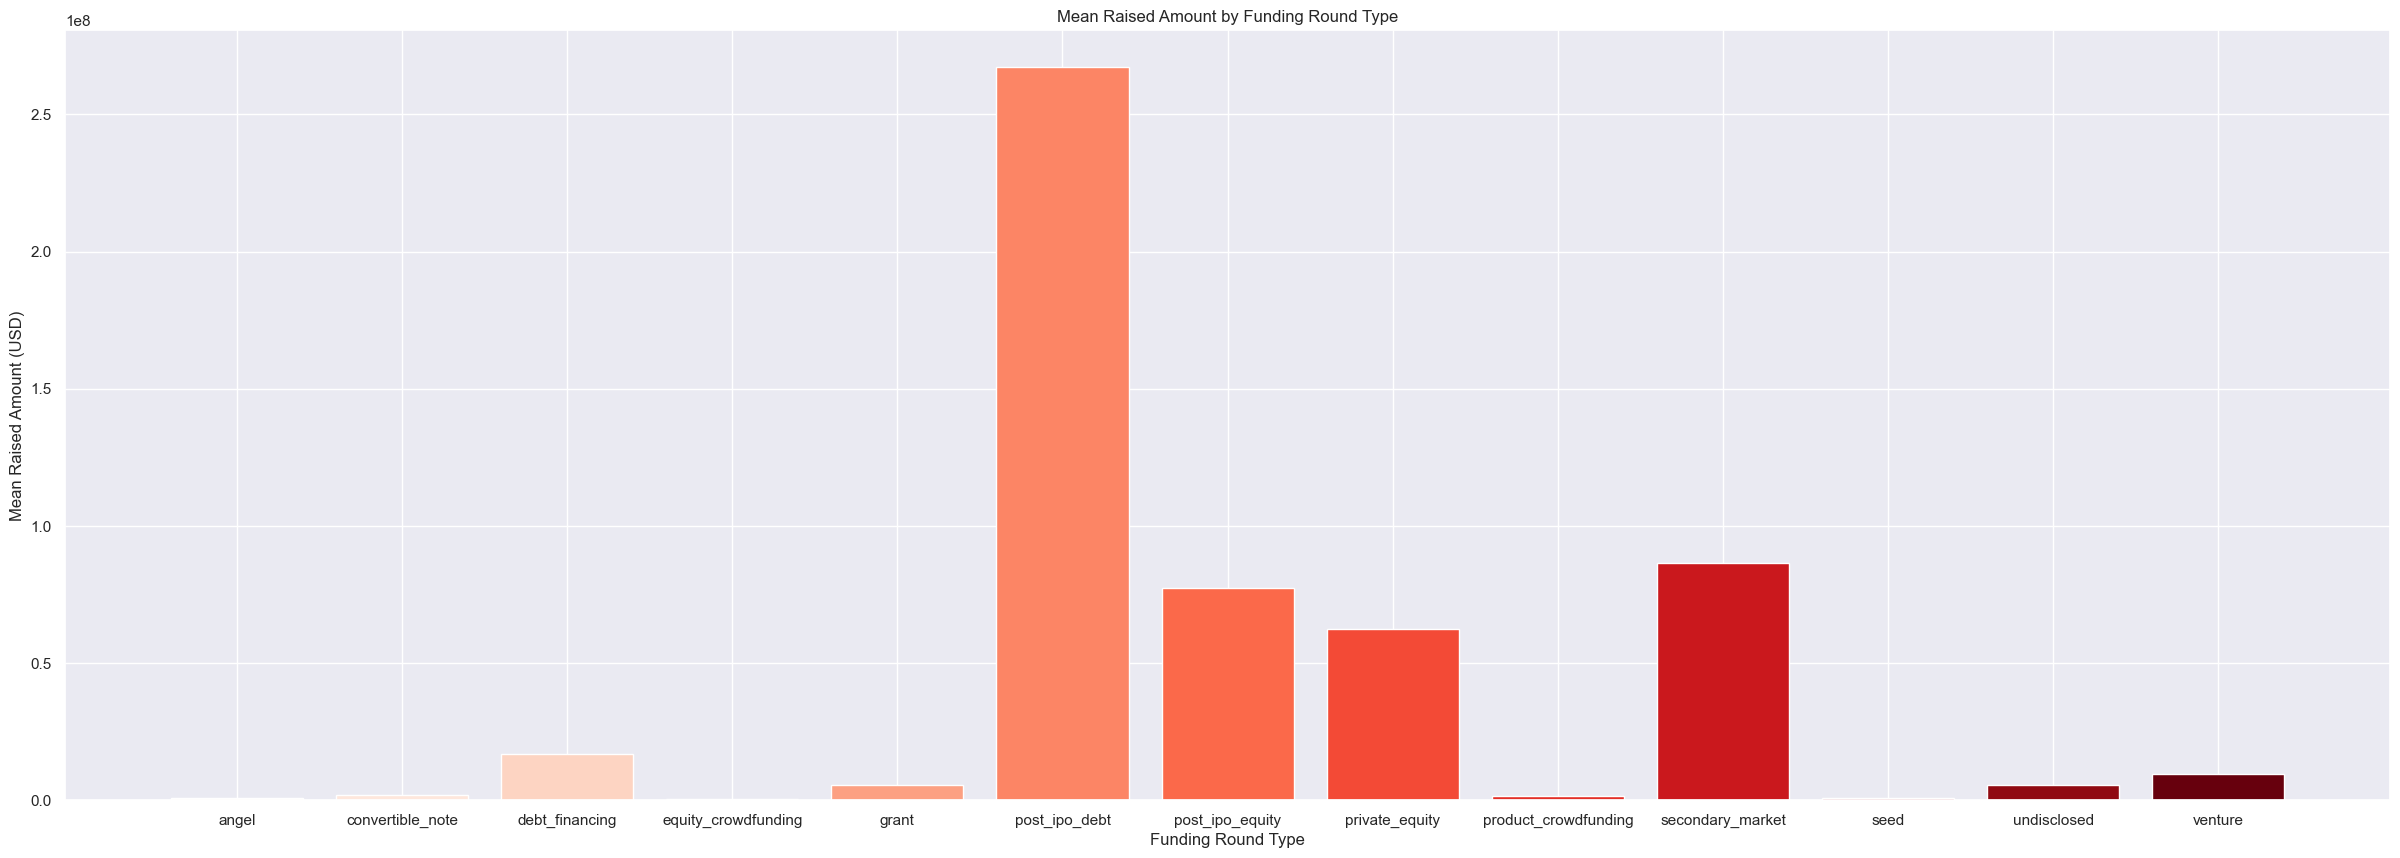

In [148]:
#Group the data
grouped = df_rd.groupby('funding_round_type')['raised_amount_usd'].mean().reset_index()

# Create the plot
colors = plt.cm.Reds(np.linspace(0, 1, len(grouped)))
fig = plt.figure(figsize=(30, 10)) 
ax = fig.add_subplot(111)
ax.bar(grouped['funding_round_type'], grouped['raised_amount_usd'], color=colors)

# Formatring and labels
ax.set_xlabel('Funding Round Type')
ax.set_ylabel('Mean Raised Amount (USD)')
ax.set_title('Mean Raised Amount by Funding Round Type')
plt.show()

In rounds that were classified as the following types:
	
Post IPO Debt

Secondary Market

Post IPO Equity

Private Equity

the mean raised amount was substantially higher than among other types.

## 2.3 Investments

In [149]:
df_inv.head(10)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_list,investor_market,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
31,/organization/knowledge-adventure,Knowledge Adventure,|Games|,Games,USA,CA,Los Angeles,Torrance,/person/william-lohse,William Lohse,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/04081f1e737343aefe19db52a1f10da7,seed,NaN,1990-01-01,01,Q1,1990-01-01,60000.0
32,/organization/saber-software-corporation,Saber Software Corporation,NaN,NaN,USA,TX,Dallas,Dallas,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/5a8983579ae0ab9667701e5288dd30e4,undisclosed,NaN,1990-02-23,02,Q1,1990-01-01,NaN
33,/organization/software-2000,Software 2000,NaN,NaN,USA,MA,Cape Cod,Hyannis Port,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/84d3eac88589e6e3307910e42c474d57,undisclosed,NaN,1990-04-18,04,Q2,1990-01-01,NaN
34,/organization/archive,Archive,NaN,NaN,USA,CA,Anaheim,Costa Mesa,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/4afc726b2eb2a17e8669a1aafd299958,undisclosed,NaN,1990-05-14,05,Q2,1990-01-01,NaN
35,/organization/intellution,Intellution,NaN,NaN,USA,MA,Boston,Norwood,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/4bcd7cccd5cece19d90da24f47cc4052,undisclosed,NaN,1990-07-17,07,Q3,1990-01-01,NaN
36,/organization/pharmaco-dynamics-research,Pharmaco Dynamics Research,NaN,NaN,USA,TX,Austin,Austin,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/d19cdb67bade9315a750381257eecf9f,undisclosed,NaN,1990-08-10,08,Q3,1990-01-01,NaN
37,/organization/interhyp,Interhyp,NaN,NaN,DEU,NaN,Munich,Munich,/organization/earlybird-venture-capital,Earlybird Venture Capital,|Venture Capital|,Venture Capital,DEU,NaN,Berlin,Berlin,/funding-round/879d2f7c941b66291c3d56a8de27dc60,undisclosed,NaN,1990-09-01,09,Q3,1990-01-01,NaN
38,/organization/renal-treatment-centers,Renal Treatment Centers,NaN,NaN,USA,PA,Philadelphia,Berwyn,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/9c464ad44611204dc3e5c08482a1362d,undisclosed,NaN,1990-09-28,09,Q3,1990-01-01,NaN
39,/organization/artisoft,Artisoft,NaN,NaN,USA,AZ,Tucson,Tucson,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/7abf76dc7a6352b85c3de441522a09c6,undisclosed,NaN,1990-10-15,10,Q4,1990-01-01,NaN
40,/organization/active-voice-corporation,Active Voice Corporation,|Social Media|,Social Media,USA,WA,Seattle,Seattle,/organization/summit-partners,Summit Partners,NaN,NaN,USA,MA,Boston,Boston,/funding-round/13bfa7d2ab7aebc0f31361dc35094efb,undisclosed,NaN,1990-10-31,10,Q4,1990-01-01,NaN


### 2.3.1 Descriptive statistics

In [150]:
df_inv.describe()

,raised_amount_usd
count,1.011430e+05
mean,1.266481e+07
std,4.724303e+07
min,0.000000e+00
25%,1.200000e+06
50%,4.600000e+06
75%,1.300000e+07
max,5.800000e+09


### 2.3.2 Funding aquired by the startups

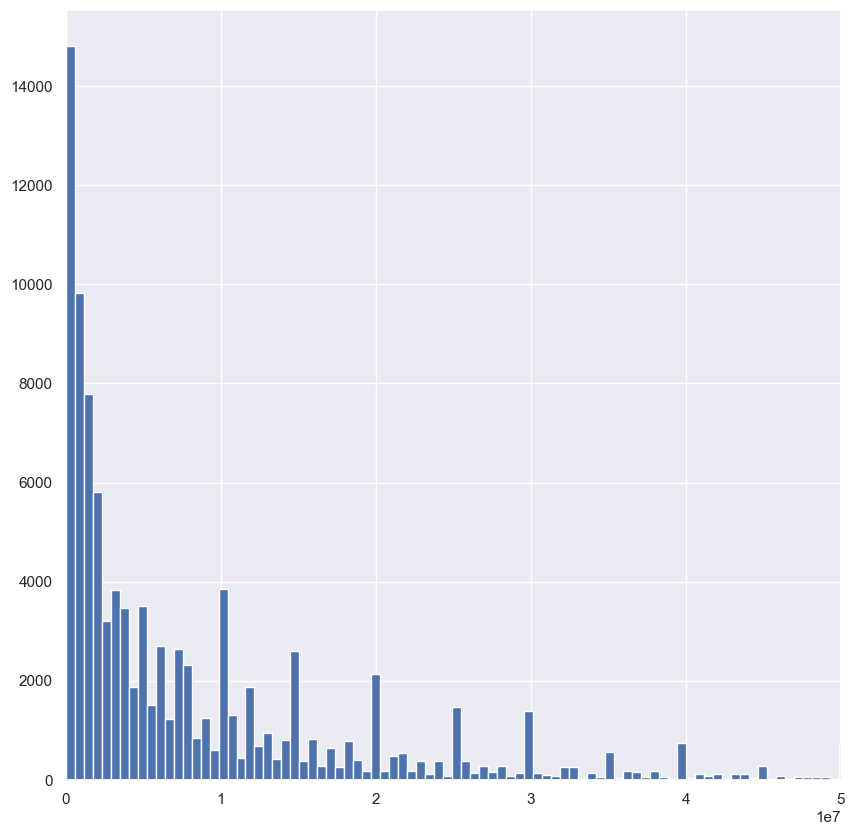

In [151]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_inv['raised_amount_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

The distribution of the investments is similar to the distributions presented in parts 2.1 and 2.2. A slighly higher number of relatevely big investments can be observed. 

### 2.3.3 Investments over time and by market category

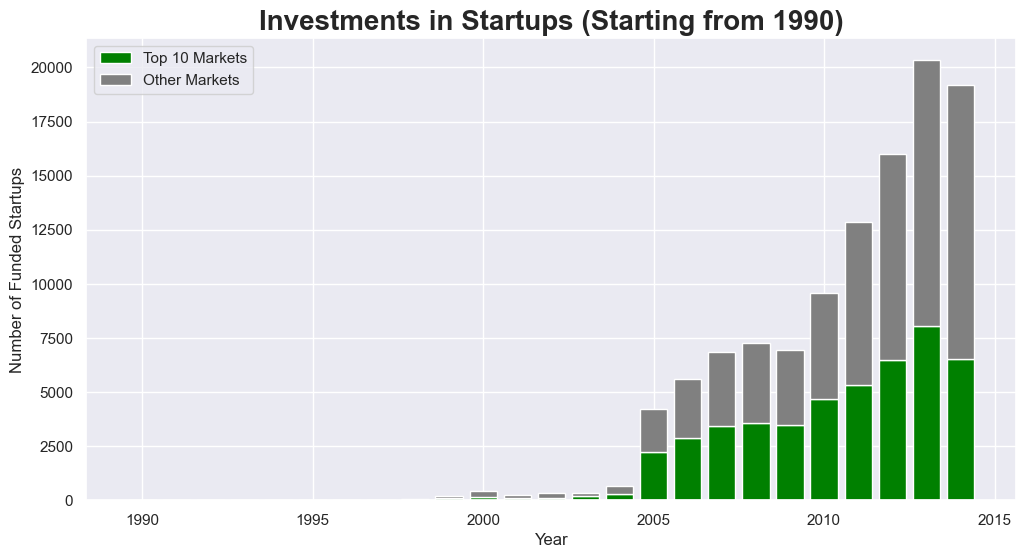

In [152]:
df_inv_1990 = df_inv[df_inv["funded_at"].dt.year >= 1990]
market_counts = df_inv_1990.groupby([df_inv_1990["funded_at"].dt.year, "company_market"])["company_name"].count().unstack(fill_value=0)
top_5_markets = market_counts.sum().nlargest(10).index.tolist()
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_5_markets].sum(axis=1)
top_5_counts = market_counts[top_5_markets].sum(axis=1)
other_counts = market_counts["Other"]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_5_counts.index, top_5_counts, color="green", label="Top 10 Markets")
ax.bar(other_counts.index, other_counts, bottom=top_5_counts, color="gray", label="Other Markets")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")
ax.set_title("Investments in Startups (Starting from 1990)", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')
ax.legend()
plt.show()

The trend corresponds to the observations made in the previous part dedicated to the funding rounds. After 2004 the number of investments has increased dynamically.

#### Different market categories

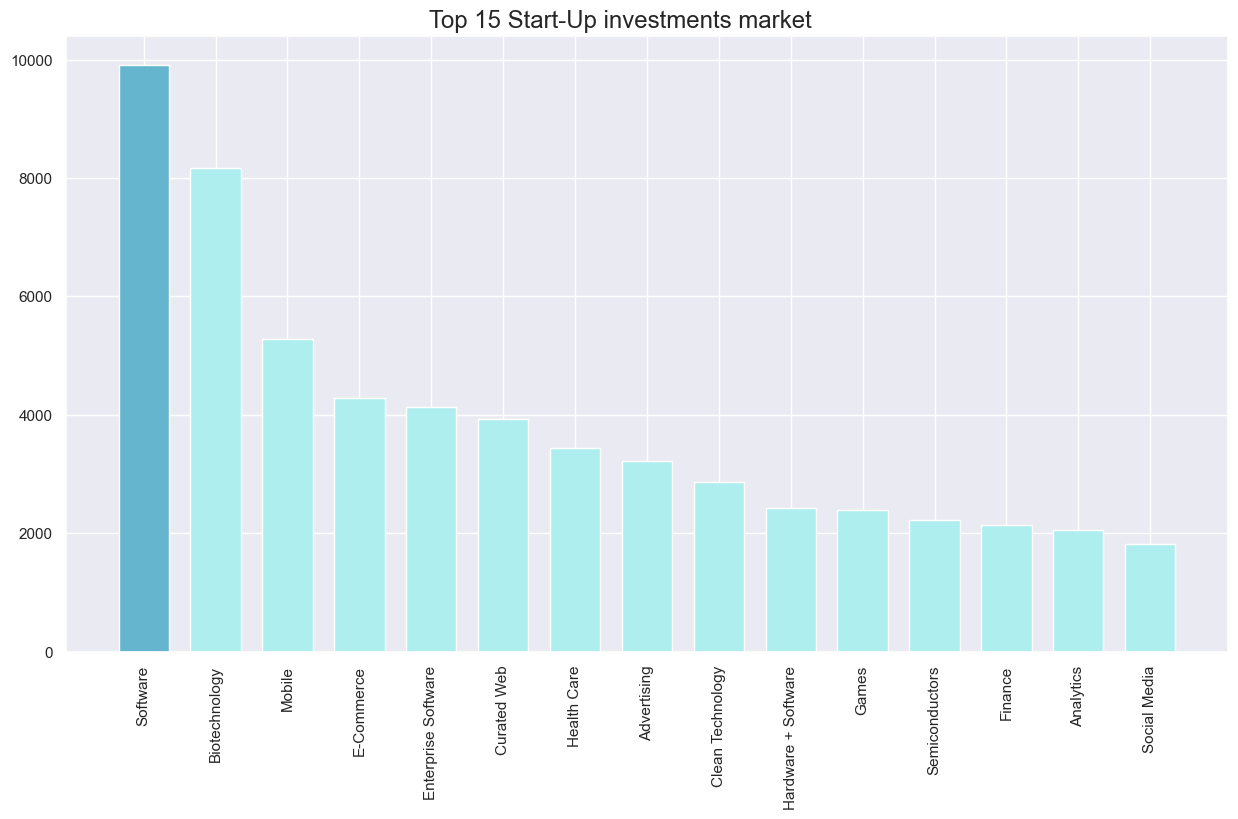

In [153]:
plt.rcParams['figure.figsize'] = 15,8

height = df_inv['company_market'].value_counts()[:15].tolist()
bars =  df_inv['company_market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up investments market ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

The top markets for investments are Software, Biotechnology and Mobile, as in the previous sections. 

### 2.3.4 Investments by country

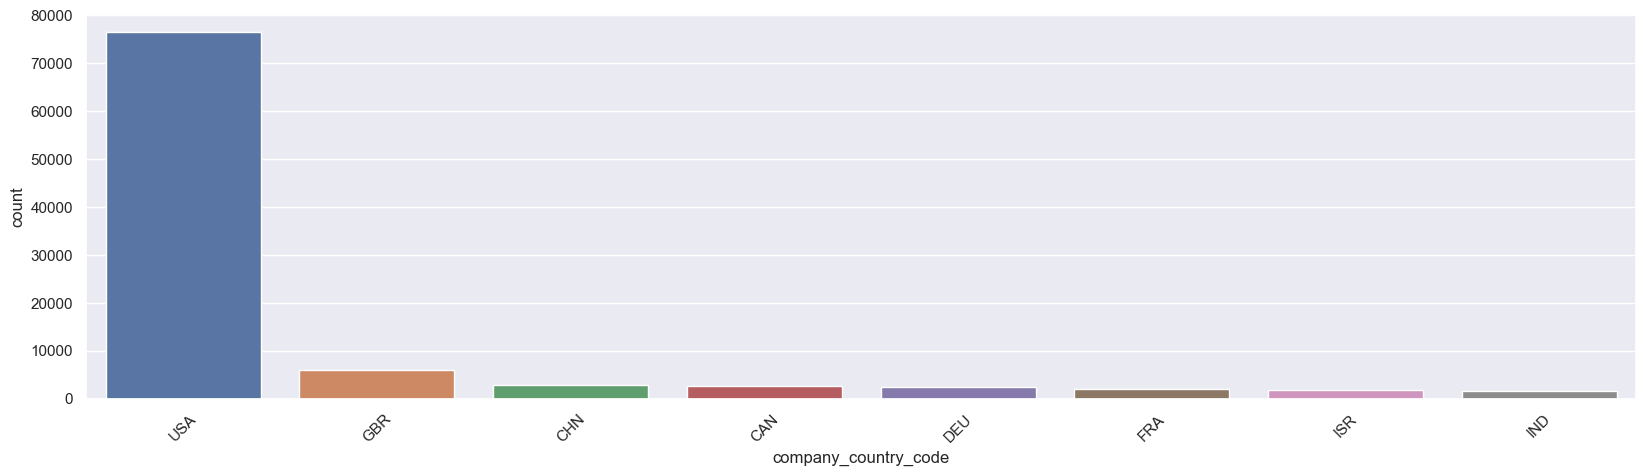

In [154]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='company_country_code', data = df_inv, order=df_inv['company_country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

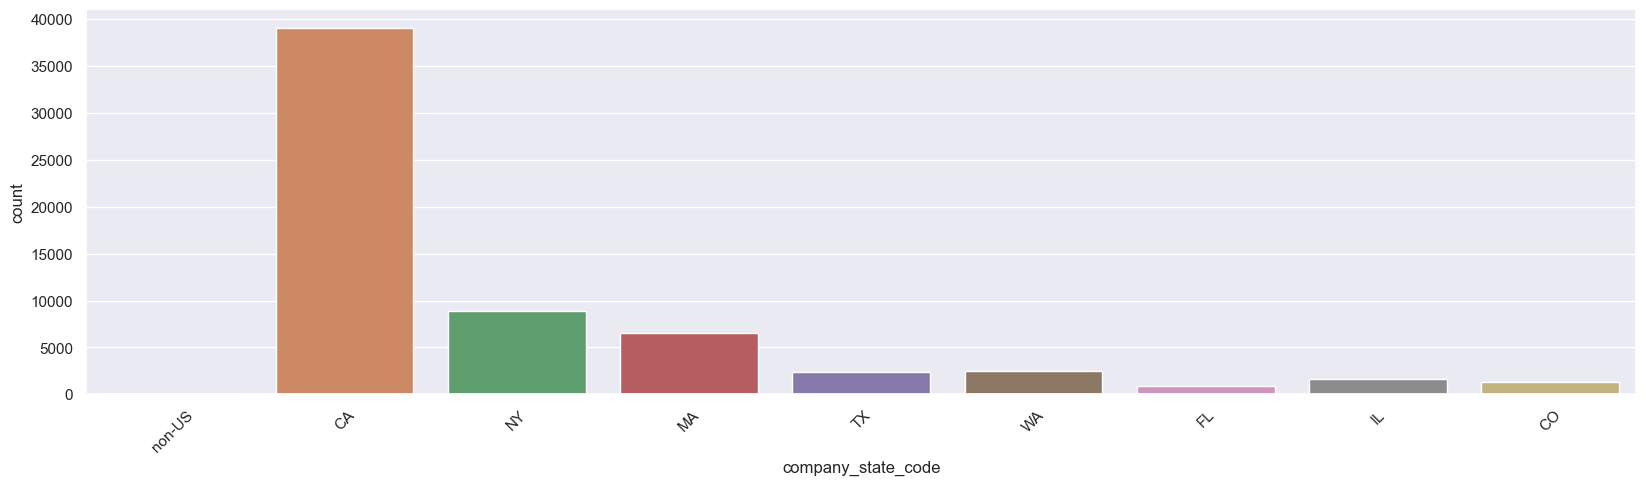

In [155]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='company_state_code', data = df_inv[(df_inv['company_country_code'] =='USA')], order=df_org['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()

Similar to parts 2.1 and 2.2, the US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.  

## 2.4 Acquisitions

In [156]:
df_aq.head(10)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10,Q4,2013-01-01,NaN,USD
1,/organization/fluff-friends,(fluff)Friends,NaN,NaN,NaN,NaN,NaN,NaN,/organization/social-gaming-network,SGN (Social Gaming Network),|Games|,Games,USA,CA,Los Angeles,Beverly Hills,2008-09-16,09,Q3,2008-01-01,NaN,USD
2,/organization/red,(RED),|Nonprofits|,Nonprofits,USA,NY,New York City,New York,/organization/nationstar-mortgage-holdings,Nationstar Mortgage Holdings,|Finance|,Finance,USA,TX,Dallas,Lewisville,2014-05-08,05,Q2,2014-01-01,18000000.0,USD
3,/organization/vandaele-holdings,.,NaN,NaN,NaN,NaN,NaN,NaN,/organization/hi7e,HI7E,NaN,NaN,USA,FL,Palm Beaches,West Palm Beach,2011-01-01,01,Q1,2011-01-01,NaN,USD
4,/organization/co-internet,.CO,|Registrars|Domains|Curated Web|,Registrars,USA,FL,Miami,Miami,/organization/neustar,Neustar,|Telecommunications|Analytics|Information Tech...,Analytics,USA,VA,"Washington, D.C.",Sterling,2014-03-20,03,Q1,2014-01-01,109000000.0,USD
5,/organization/vantronix,.vantronix,|Cloud Security|Network Security|Security|,Cloud Security,DEU,NaN,Hanover,Hanover,/organization/compumatica,Compumatica,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01,01,Q1,2011-01-01,NaN,USD
6,/organization/003-ru,003.RU,NaN,NaN,RUS,NaN,Moscow,Moscow,/organization/media-saturn,Media Saturn,|Sales and Marketing|Media|Enterprise Software|,Media,ESP,NaN,Barcelona,Barcelona,2012-07-23,07,Q3,2012-01-01,NaN,USD
7,/organization/0958572-b-c-ltd,0958572 B.C. Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,/organization/atlas-intellectual-property-mana...,ATLAS Intellectual Property Management Co.,|Telecommunications|Mobile|Finance|,Mobile,USA,WA,Seattle,Seattle,2012-02-02,02,Q1,2012-01-01,9000000.0,USD
8,/organization/1-nation-technology,1 Nation Technology,NaN,NaN,NaN,NaN,NaN,NaN,/organization/vology,Vology,NaN,NaN,USA,FL,Tampa,Oldsmar,2006-01-01,01,Q1,2006-01-01,NaN,USD
9,/organization/1-800-contacts,1-800 Contacts,|Consumer Goods|Retail|,Retail,USA,UT,Salt Lake City,Draper,/organization/thomas-h-lee-partners,Thomas H. Lee Partners,|Investment Management|Business Development|Im...,Business Development,USA,MA,Boston,Boston,2014-01-07,01,Q1,2014-01-01,NaN,USD


### 2.4.1 Descriptive statistics

In [157]:
df_aq.describe()

,price_amount
count,3.702000e+03
mean,7.400703e+08
std,4.051897e+09
min,0.000000e+00
25%,1.800000e+07
50%,8.050500e+07
75%,3.397500e+08
max,1.500000e+11


### 2.4.2 Funding aquired by the startups

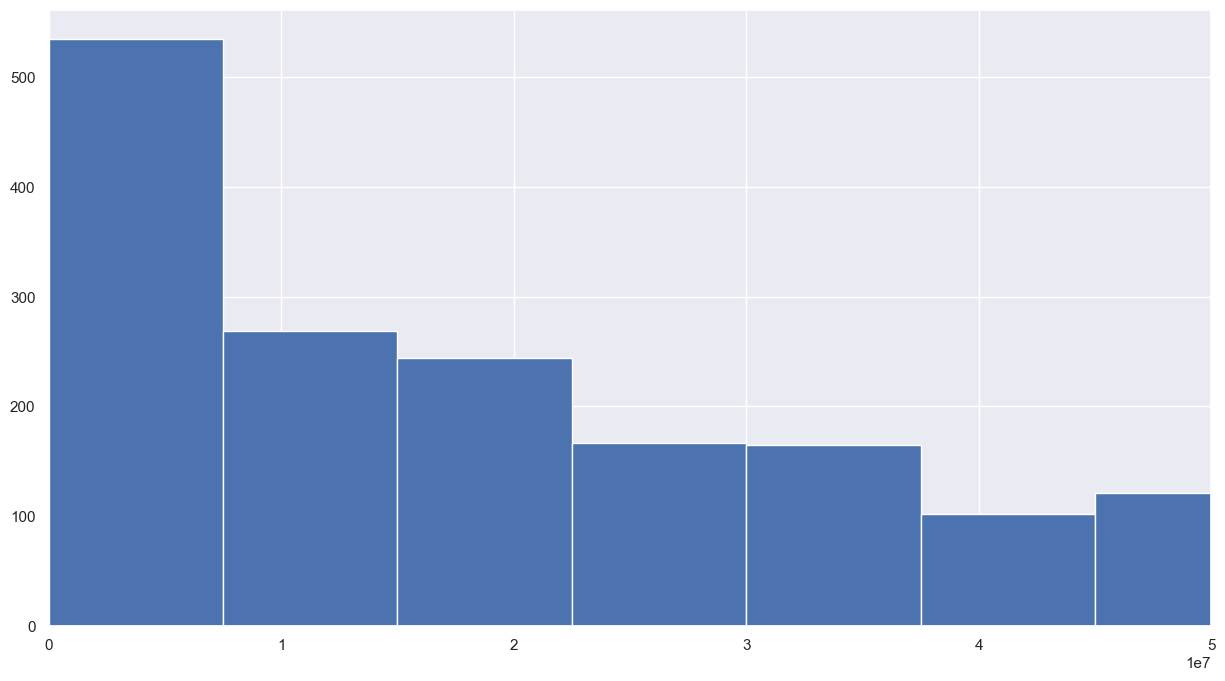

In [158]:
#Runs long! - 60s
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_aq['price_amount'], bins = 20000)
ax.set_xlim(left=0, right=50000000);

### 2.4.3 Aquisitions over time and by market

Companies that were aquired, 5 top industries highlighted

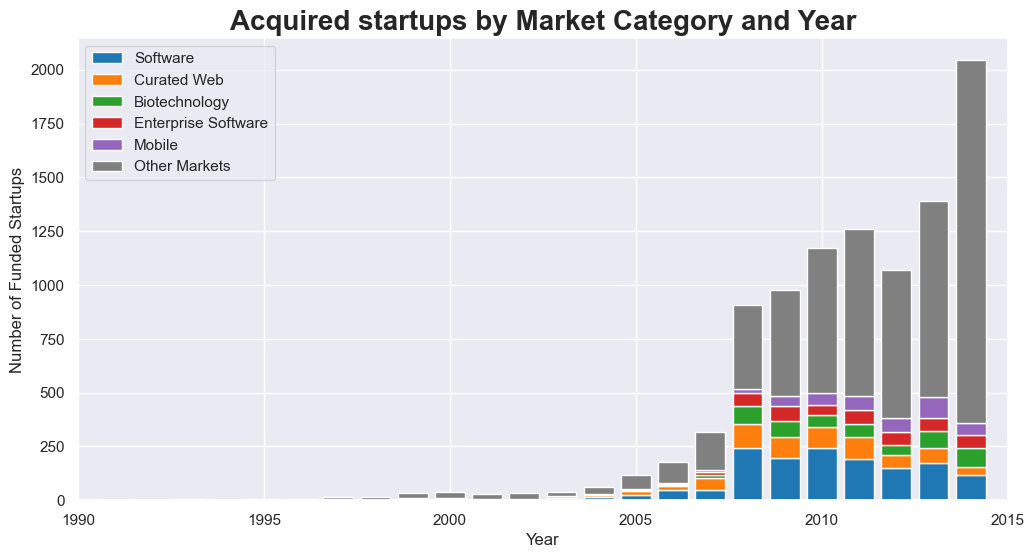

In [159]:
market_counts = df_aq.groupby([df_aq["acquired_at"].dt.year, "company_market"])["company_name"].count().unstack(fill_value=0)

top_10_markets = market_counts.sum().nlargest(5).index.tolist()

for market in top_10_markets:
    market_counts[market] = market_counts[market] if market in market_counts.columns else 0
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

market_colors = plt.get_cmap('tab10').colors
for i, market in enumerate(top_10_markets):
    ax.bar(market_counts.index, market_counts[market], bottom=market_counts[top_10_markets[:i]].sum(axis=1), color=market_colors[i], label=market)
ax.bar(market_counts.index, market_counts["Other"], bottom=market_counts[top_10_markets].sum(axis=1), color="gray", label="Other Markets")

ax.set_xlim(left=1990, right=2015)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")

ax.set_title("Acquired startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')

ax.legend()

plt.show()



Similar trends to previous sections can be observed - most acquired companies are from Software market, and the top 5 market consitutes a great part of all of the acquisitions.

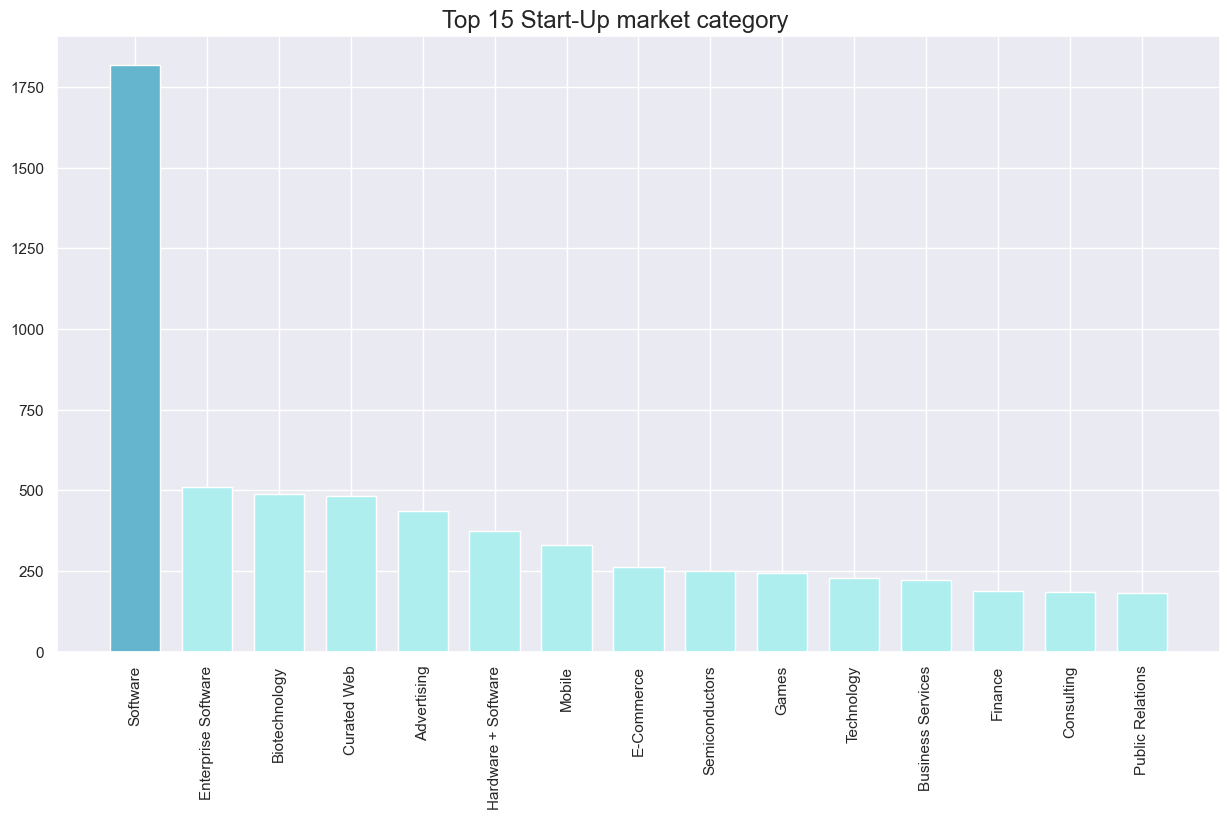

In [160]:
plt.rcParams['figure.figsize'] = 15,8

height = df_aq['acquirer_market'].value_counts()[:15].tolist()
bars =  df_aq['acquirer_market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up market category", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Altough the trends observed on the graph above are similar to the previous sections, what is worth noting is that software companies are acquired significantly more often than others.

### 2.4.4 Acquisitions in different countries

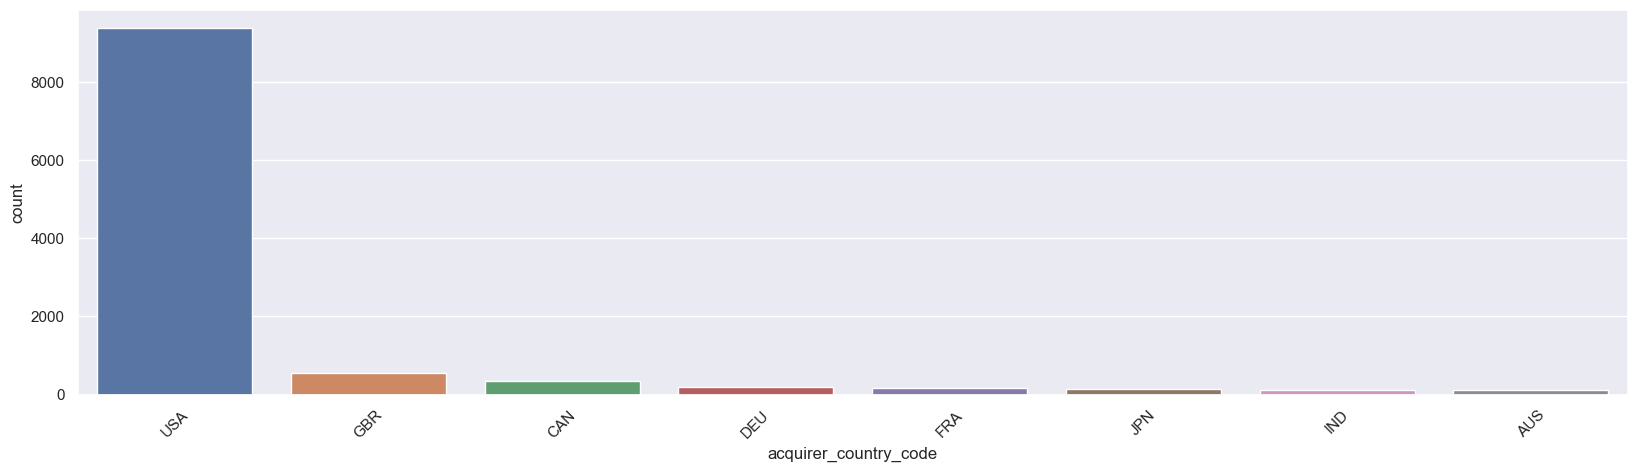

In [161]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='acquirer_country_code', data = df_aq, order=df_aq['acquirer_country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

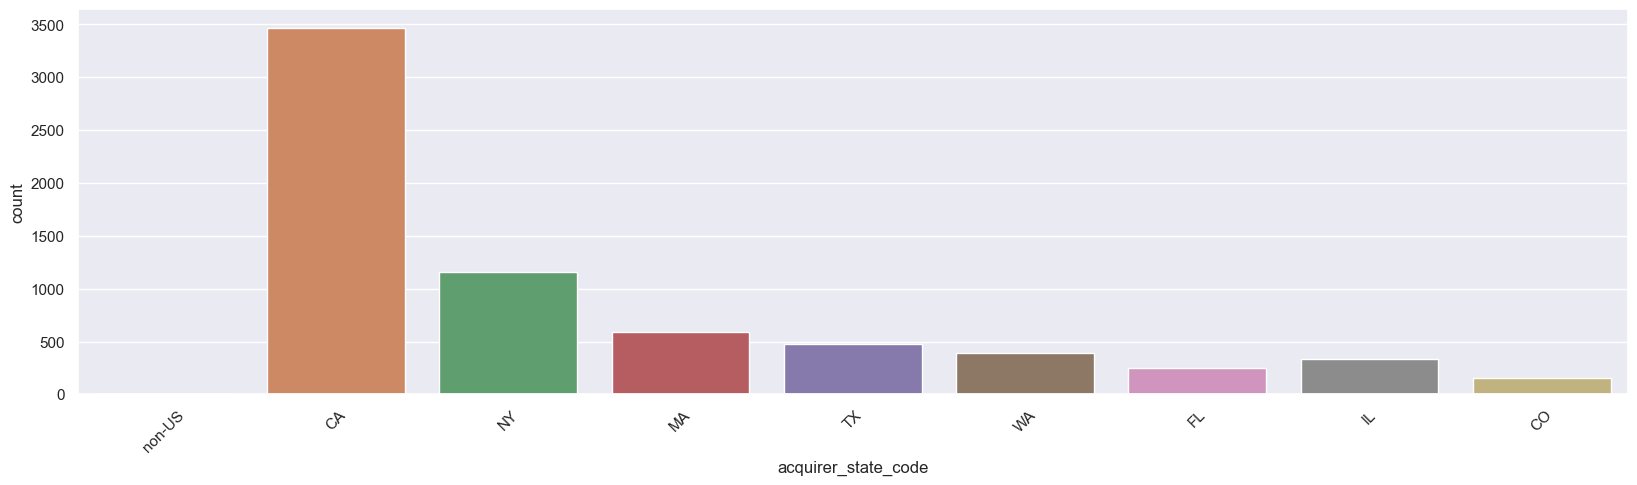

In [162]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='acquirer_state_code', data = df_aq[(df_aq['acquirer_country_code'] =='USA')], order=df_org['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()

Similar to parts 2.1 and 2.2, the US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.

### 2.4.5 Aquisitions over quarters

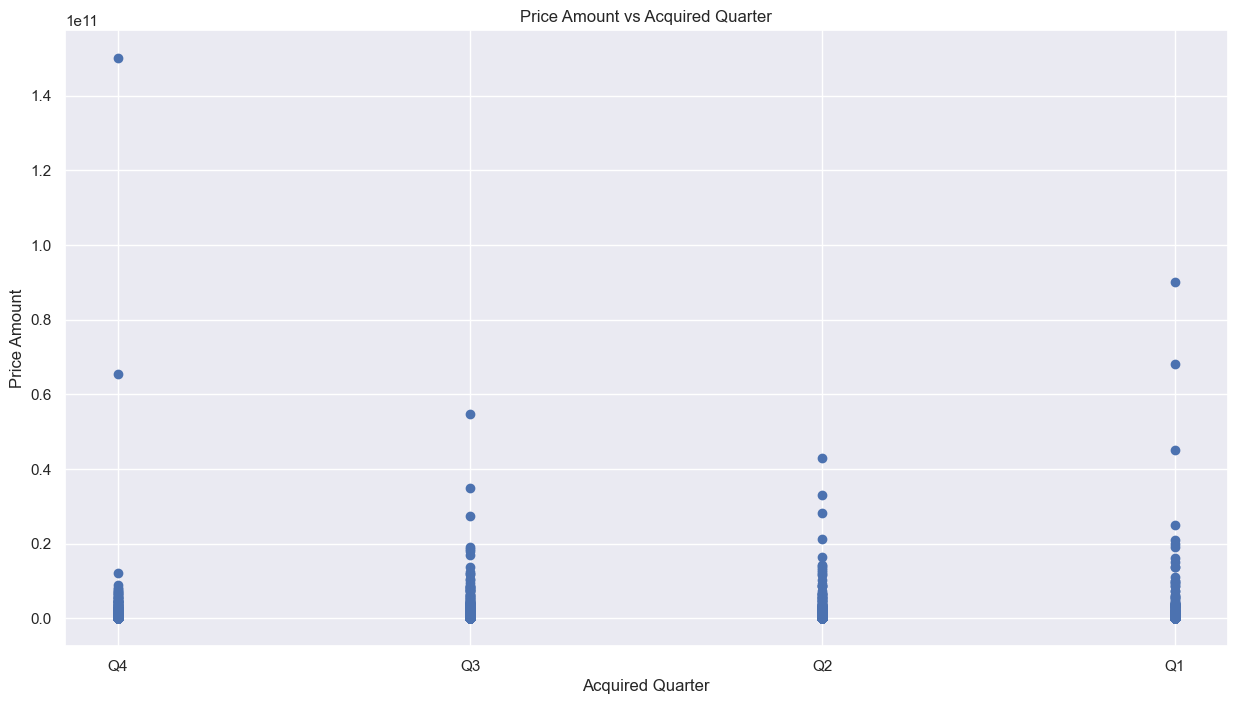

In [163]:
df_aq['acquired_quarter'] = df_aq['acquired_quarter'].astype(str)

plt.scatter(df_aq['acquired_quarter'], df_aq['price_amount'])
plt.xlabel('Acquired Quarter')
plt.ylabel('Price Amount')
plt.title('Price Amount vs Acquired Quarter')
plt.show()

Text(0.5, 1.0, 'target boxplot')

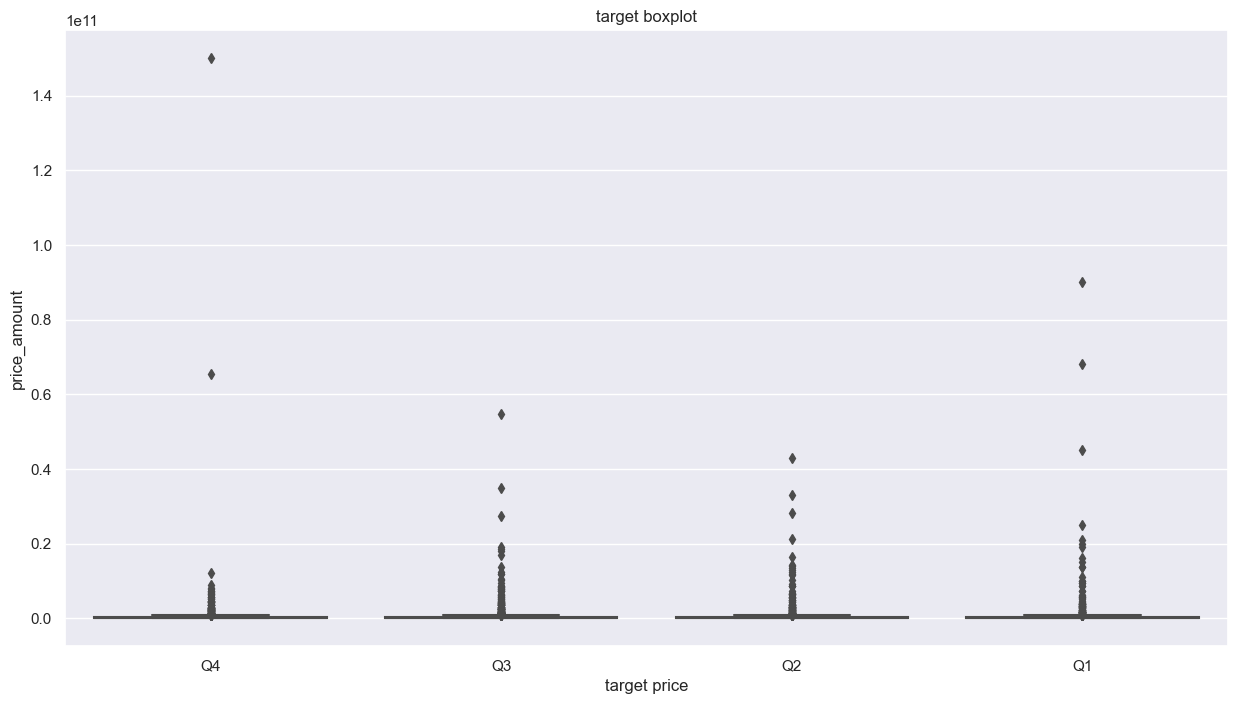

In [164]:
sns.boxplot(x='acquired_quarter', y="price_amount", data=df_aq)
plt.xlabel('target price')
plt.title("target boxplot")



In [165]:
df_aq.groupby(df_aq["acquired_quarter"])["price_amount"].mean()

acquired_quarter
Q1    9.121500e+08
Q2    6.724910e+08
Q3    7.294712e+08
Q4    6.798954e+08
Name: price_amount, dtype: float64

As seen above, the transaction prices are quite similar in case of quarters 2-4, but in the first quarter the mean acquistion price is much higher.

In [166]:
df_aq.groupby(df_aq["acquired_month"])["price_amount"].mean()

acquired_month
01    7.527818e+08
02    1.073608e+09
03    9.964317e+08
04    5.162739e+08
05    8.096348e+08
06    6.607607e+08
07    7.547915e+08
08    8.056856e+08
09    6.396868e+08
10    8.017209e+08
11    7.839094e+08
12    4.386864e+08
Name: price_amount, dtype: float64

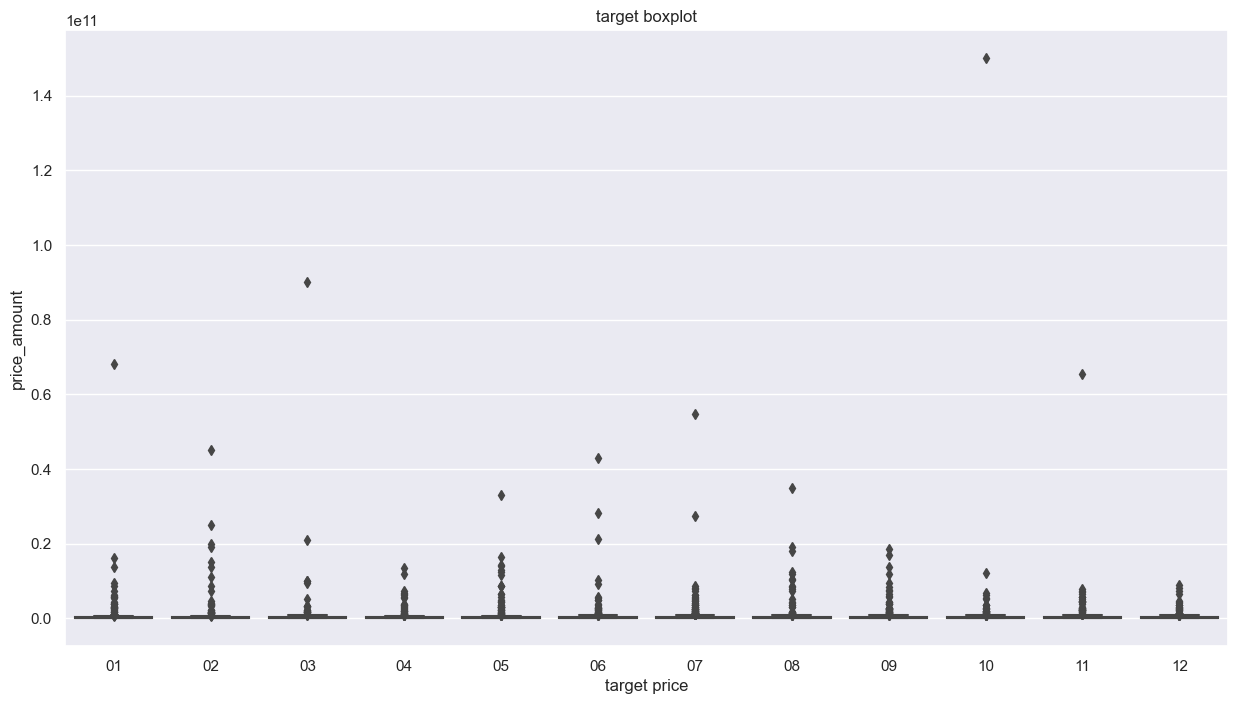

In [167]:
month_order = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
sns.boxplot(x='acquired_month', y="price_amount", data=df_aq, order=month_order)
plt.xlabel('target price')
plt.title("target boxplot")
plt.show()

# 3. Exploratory Data Analysis - Merged Data Set (df_full)

In the previous section, the four data sets were analyzed individually. After that, the EDA on merged data was conducted (following the code below). Due to the problematic interpreatation of the merged data set (one company can be present in many rows) it was decided that this part is of less importance and should be regarded as an additional material.

So, the following section is quite similar to section 2 in regards to the data exploration. No significant differences important for understanding the data set and future feature engineering were noticed.

In [168]:
#Take a look at the data:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99376 entries, 0 to 99375
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   permalink                99376 non-null  object        
 1   name                     99376 non-null  object        
 2   homepage_url             96234 non-null  object        
 3   category_list            97620 non-null  object        
 4   market                   99376 non-null  object        
 5   funding_total_usd        99376 non-null  int64         
 6   status                   99376 non-null  object        
 7   country_code             99376 non-null  object        
 8   state_code               99376 non-null  object        
 9   region                   99376 non-null  object        
 10  city                     99376 non-null  object        
 11  funding_rounds           99376 non-null  int64         
 12  founded_at               99376 n

In [169]:
df_full.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code,investor_permalink,investor_name,investor_country_code,investor_region,investor_city
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30 00:00:00,2012-06-30 00:00:00,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,Unknown,2012-06-30,6.0,2.0,2012.0,1750000.0,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,NaN,USD,/organization/afsquare,AFSquare,USA,Los Angeles,Culver City
1,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30 00:00:00,2012-06-30 00:00:00,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,Unknown,2012-06-30,6.0,2.0,2012.0,1750000.0,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,NaN,USD,/organization/first-round-capital,First Round,USA,SF Bay Area,San Francisco
2,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30 00:00:00,2012-06-30 00:00:00,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,Unknown,2012-06-30,6.0,2.0,2012.0,1750000.0,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,NaN,USD,/organization/innovation-endeavors,Innovation Endeavors,USA,SF Bay Area,Palo Alto
3,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000,operating,EST,non-US,Tallinn,Tallinn,1,2012-10-26,2012-08-09 00:00:00,2012-08-09 00:00:00,/funding-round/f06b420775f7cb6c1541a9db526534bb,seed,Unknown,2012-08-09,8.0,3.0,2012.0,40000.0,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,0.0,None,/organization/start-up-chile,Start-Up Chile,CHL,Santiago,Santiago
4,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000,operating,GBR,non-US,London,London,1,2011-04-01,2011-04-01 00:00:00,2011-04-01 00:00:00,/funding-round/33c3f135f05d7b734b8d7b7c8ae82647,seed,Unknown,2011-04-01,4.0,2.0,2011.0,1500000.0,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,0.0,None,None,None,None,None,None


In [170]:
df_full.shape

(99376, 42)

In [171]:
#Total number of startups
len(df_full['name'].unique())

33946

#### Change the data types and the notation

In [172]:
#Change the format to avoid printing numbers in a scientific format
pd.options.display.float_format = '{:.2f}'.format

#### Descriptive statistics

In [173]:
df_full.describe()

,funding_total_usd,funding_rounds,funded_month,funded_quarter,funded_year,raised_amount_usd,acquired_month,acquired_quarter,acquired_year,price_amount
count,99376.00,99376.00,99376.00,99376.00,99376.00,99376.00,12986.00,12986.00,12986.00,91444.00
mean,39847423.25,3.24,6.34,2.46,2010.80,11037259.86,6.62,2.55,2011.51,30629663.25
std,133844470.98,2.28,3.44,1.11,2.87,45551023.96,3.39,1.10,2.30,1415957091.47
min,0.00,1.00,1.00,1.00,1990.00,-70000000.00,1.00,1.00,1996.00,0.00
25%,1350000.00,1.00,3.00,1.00,2009.00,425000.00,4.00,2.00,2010.00,0.00
50%,9900000.00,3.00,6.00,2.00,2012.00,3000000.00,7.00,3.00,2012.00,0.00
75%,38805883.00,4.00,9.00,3.00,2013.00,10750000.00,10.00,4.00,2013.00,0.00
max,5700000000.00,18.00,12.00,4.00,2015.00,3500000000.00,12.00,4.00,2014.00,150000000000.00


#### Correlation plot

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1409999165.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_full.corr(),annot=True,cmap='cubehelix_r')


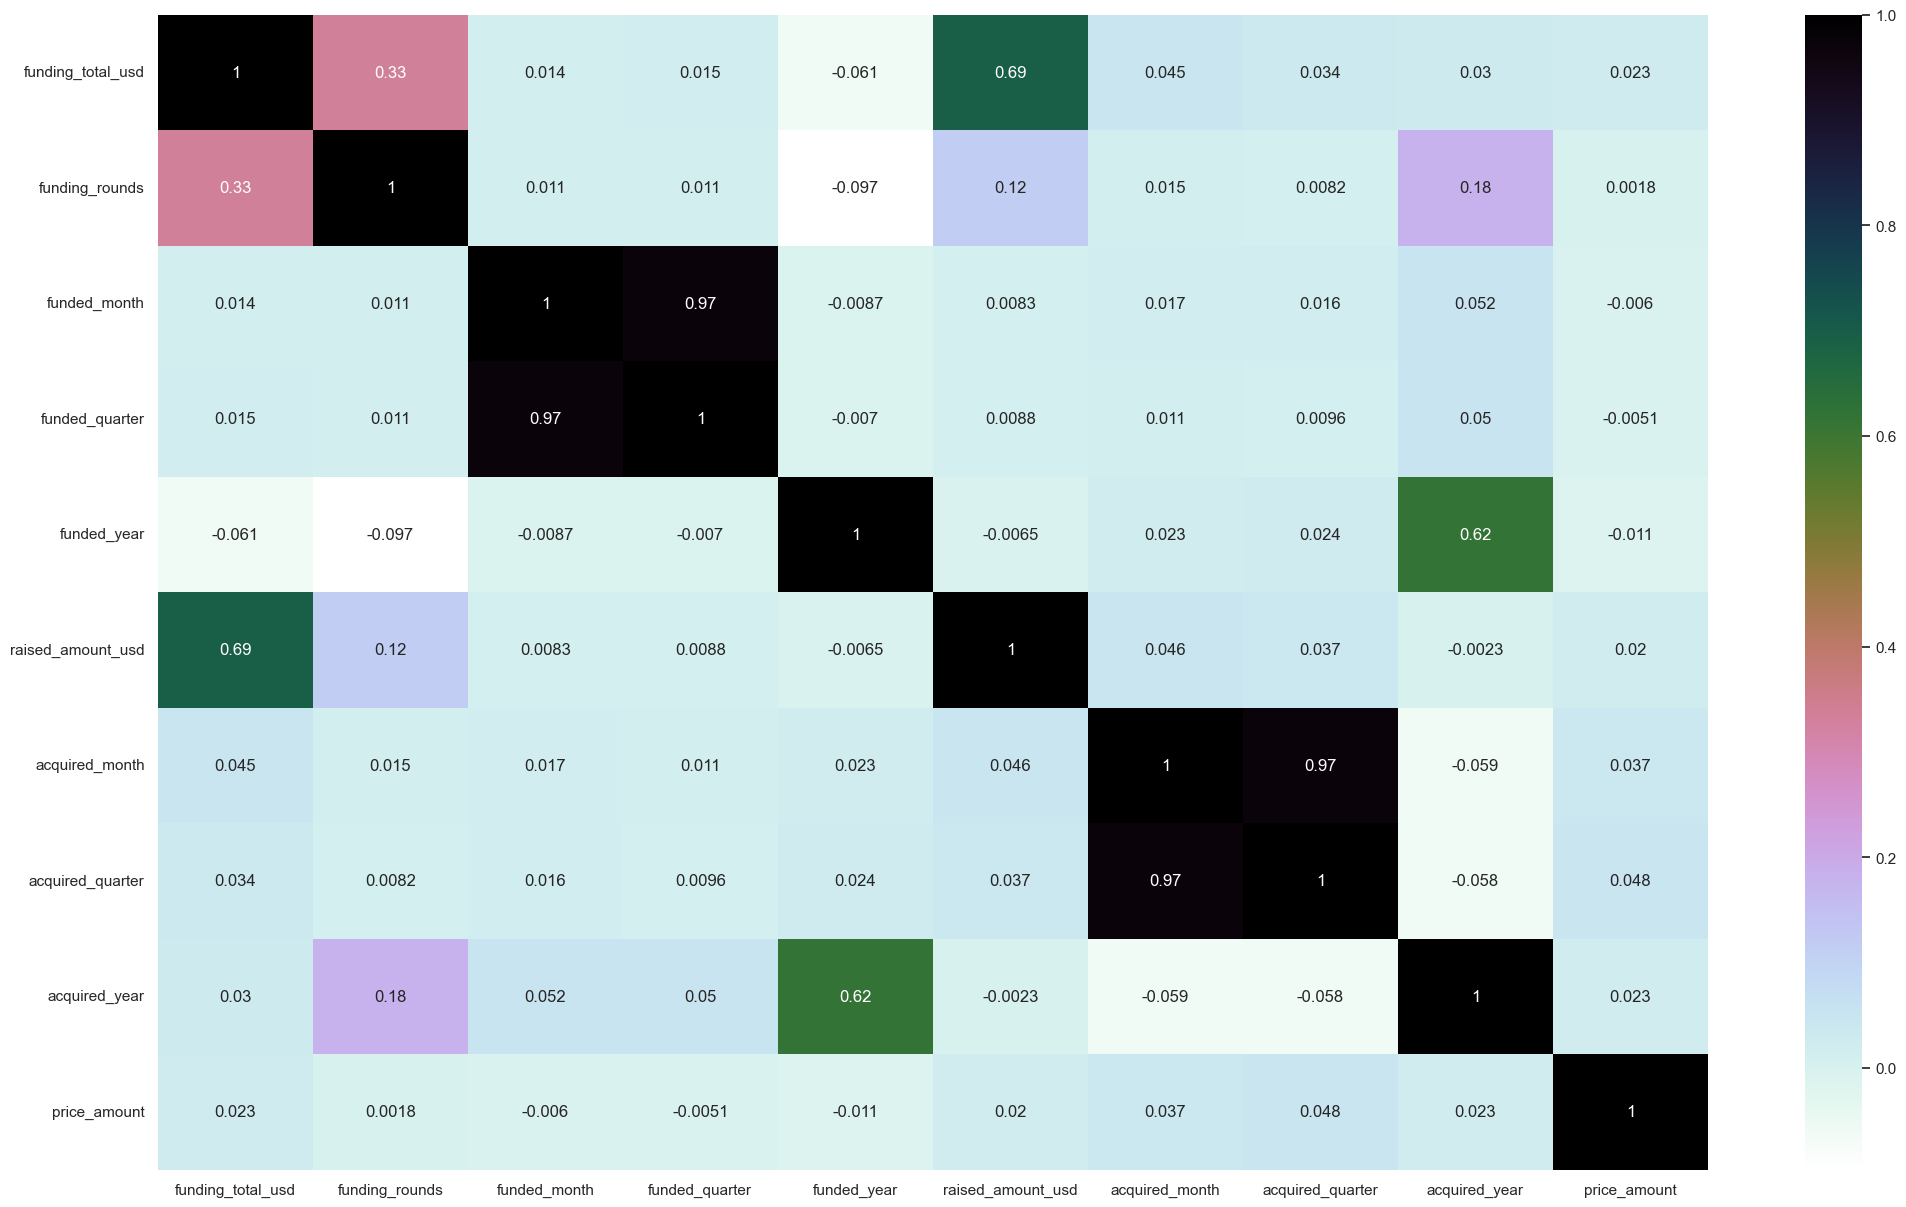

In [174]:
plt.figure(figsize=(25,15)) 
sns.heatmap(df_full.corr(),annot=True,cmap='cubehelix_r') 
plt.show()

#### Funding aquired by the startups

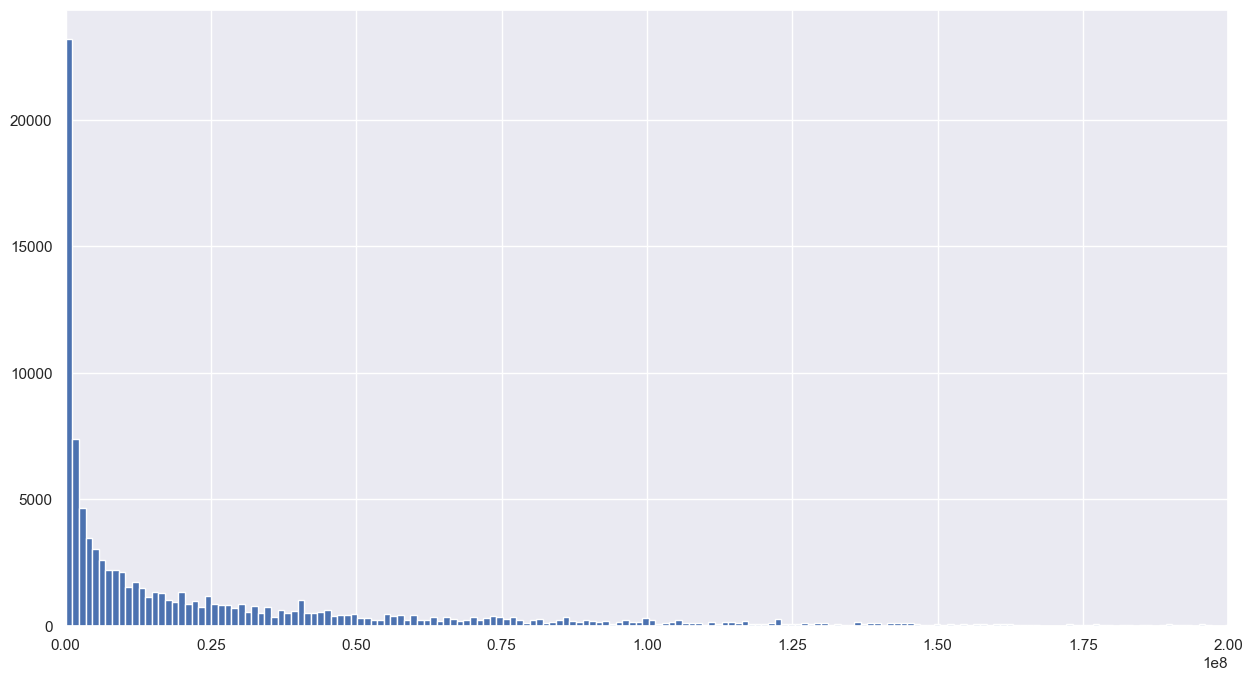

In [175]:
#Histogram of total funding aquired by the startups

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_full['funding_total_usd'], bins = 5000)
ax.set_xlim(left=0, right=200000000);

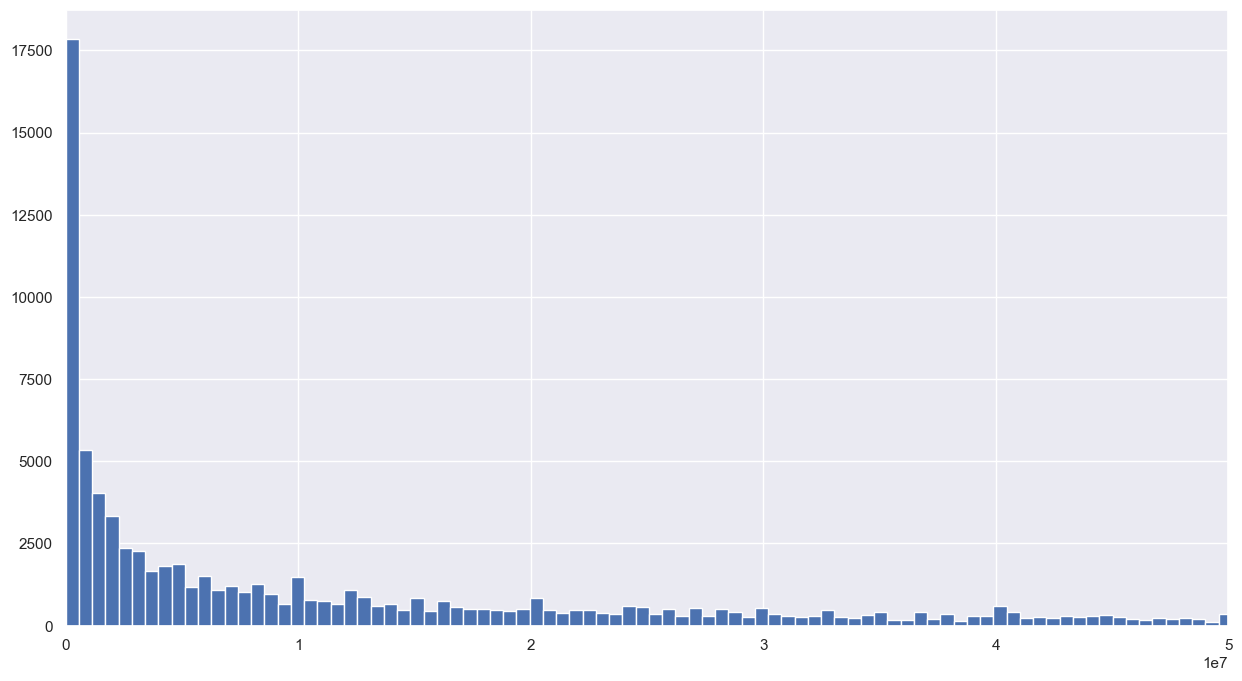

In [176]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_full['funding_total_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

#### Top startups

In [177]:
pd.set_option('display.max_columns', None)

#### Status of the start-ups

In [178]:
df_full['status'].value_counts()

operating    81210
acquired     12894
closed        3675
Unknown       1597
Name: status, dtype: int64

#### Total funding by the market

In [179]:
len(df_full['market'].unique())

721

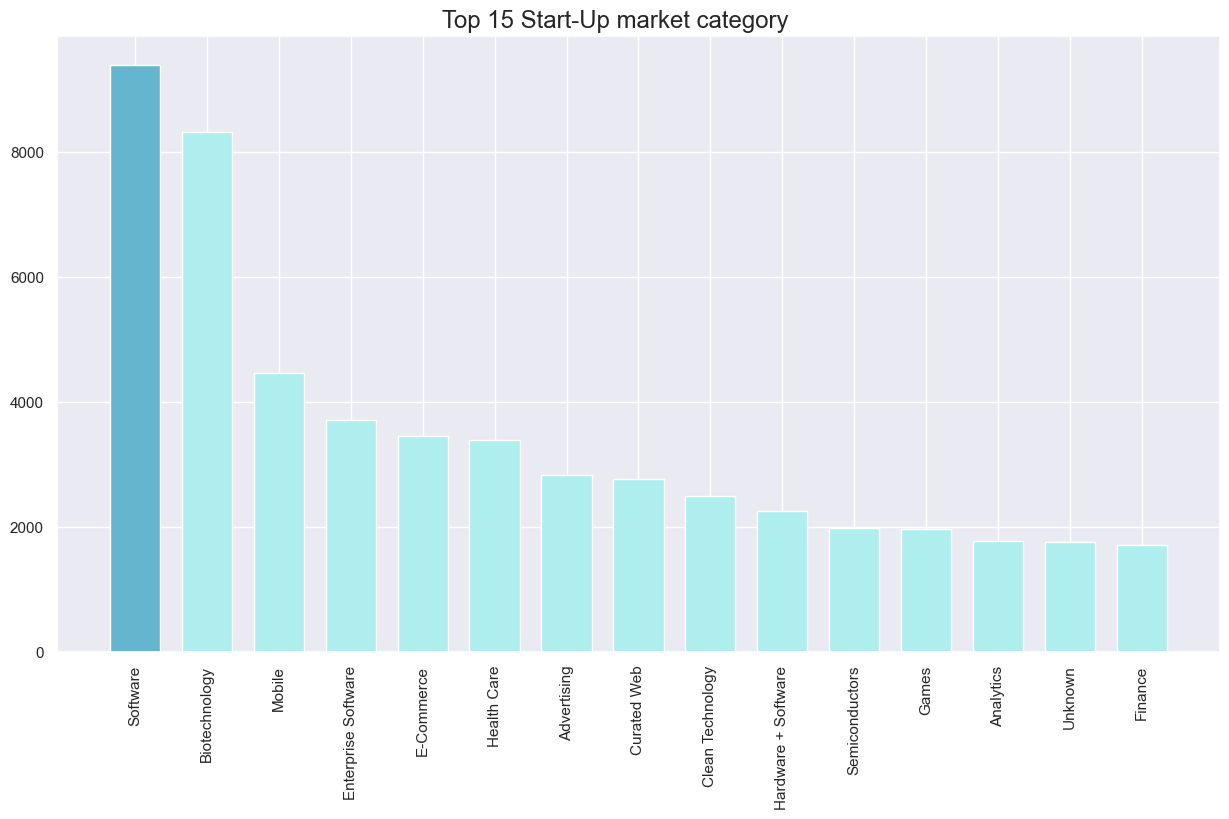

In [180]:
plt.rcParams['figure.figsize'] = 15,8

height = df_full['market'].value_counts()[:15].tolist()
bars =  df_full['market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up market category", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

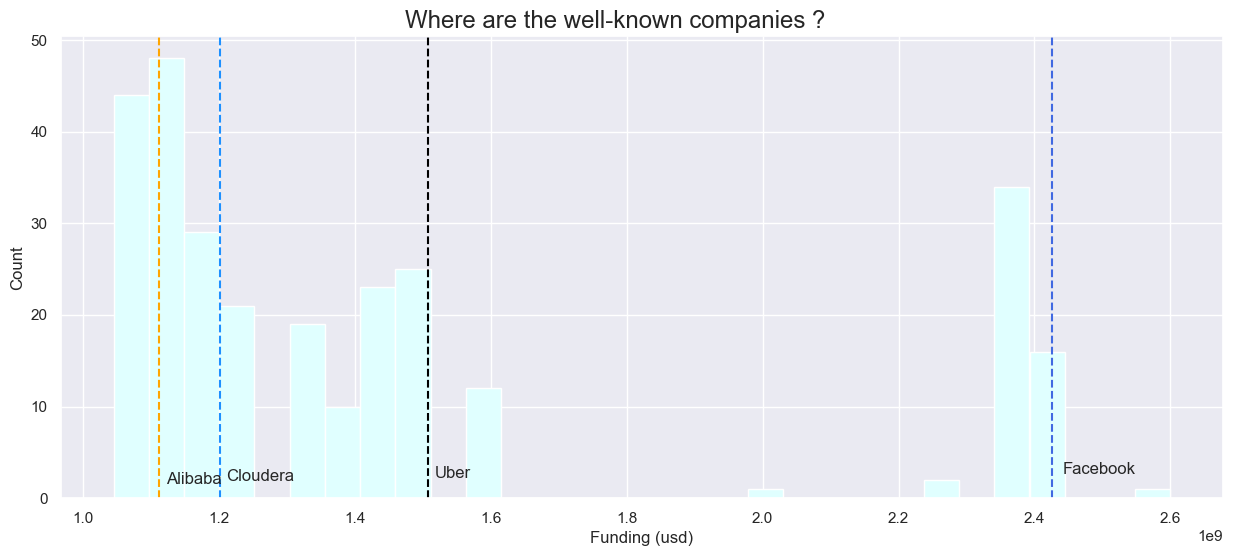

In [181]:
Facebook_total_funding = df_full['funding_total_usd'][df_full['name']=="Facebook"].values[0]
Uber_total_funding = df_full['funding_total_usd'][df_full['name']=="Uber"].values[0]
Alibaba_total_funding = df_full['funding_total_usd'][df_full['name']=="Alibaba"].values[0]
Cloudera_total_funding = df_full['funding_total_usd'][df_full['name']=="Cloudera"].values[0]

plt.rcParams['figure.figsize'] = 15,6

plt.hist(df_full['funding_total_usd'][(df_full['funding_total_usd'] >= 1000000000)&(df_full['funding_total_usd'] <= 3000000000)].dropna(), bins=30,color = 'lightcyan' )
plt.ylabel('Count')
plt.xlabel('Funding (usd)')
plt.title("Where are the well-known companies ? ", fontdict=None, position= [0.48,1.05], size = 'x-large')

plt.axvline(Facebook_total_funding,color='royalblue',linestyle ="--")
plt.text(Facebook_total_funding+15000000, 2.6,"Facebook")

plt.axvline(Uber_total_funding,color='black',linestyle ="--")
plt.text(Uber_total_funding+10000000, 2.2,"Uber")

plt.axvline(Cloudera_total_funding,color='dodgerblue',linestyle ="--")
plt.text(Cloudera_total_funding+10000000, 1.9,"Cloudera")

plt.axvline(Alibaba_total_funding,color='orange',linestyle ="--")
plt.text(Alibaba_total_funding+10000000, 1.6,"Alibaba")
#plt.ticklabel_format(style='plain')



plt.show()

#### How was the distribution of the funding given the economic events

In [182]:
df_full['founded_at'] = pd.to_datetime(df_full['founded_at'])

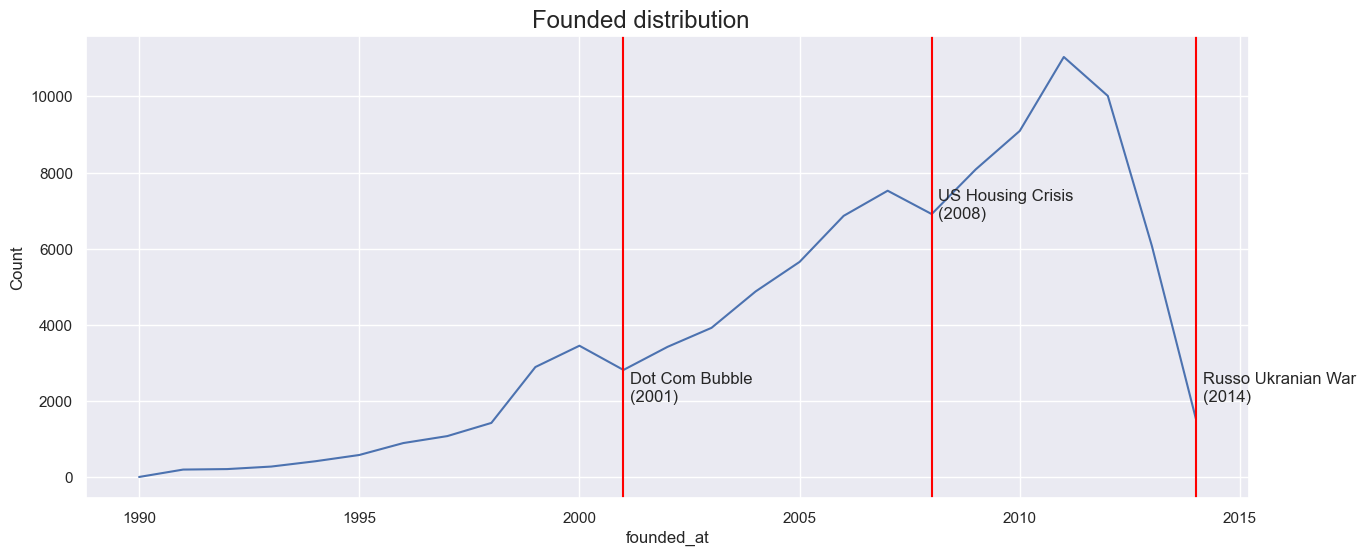

In [183]:
plt.rcParams['figure.figsize'] = 15,6
df_full['name'].groupby(df_full["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Founded distribution ", fontdict=None, position= [0.48,1.05], size = 'x-large')

plt.axvline(2008,color='red')
plt.text(2008+0.15, 6800,"US Housing Crisis \n(2008)")

plt.axvline(2001,color='red')
plt.text(2001+0.15, 2000,"Dot Com Bubble \n(2001)")

plt.axvline(2014,color='red')
plt.text(2014+0.15, 2000,"Russo Ukranian War \n(2014)")
plt.show()

### When the companies were founded?

In [184]:
df_full['founded_at'] = pd.to_datetime(df_full['founded_at'], errors = 'coerce' )

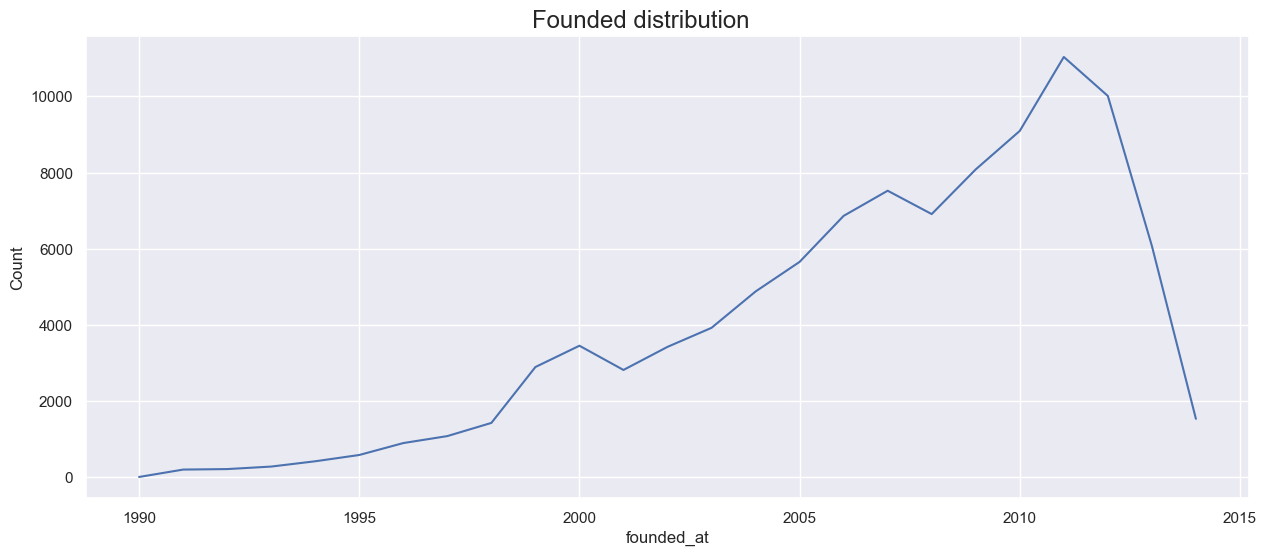

In [185]:
plt.rcParams['figure.figsize'] = 15,6
df_full['name'].groupby(df_full["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Founded distribution ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

In [186]:
Facebook_founded_year = df_full['founded_at'][df_full['name']=="Facebook"].dt.year.values[0]
Uber_founded_year  = df_full['founded_at'][df_full['name']=="Uber"].dt.year.values[0]
Alibaba_founded_year  = df_full['founded_at'][df_full['name']=="Alibaba"].dt.year.values[0]

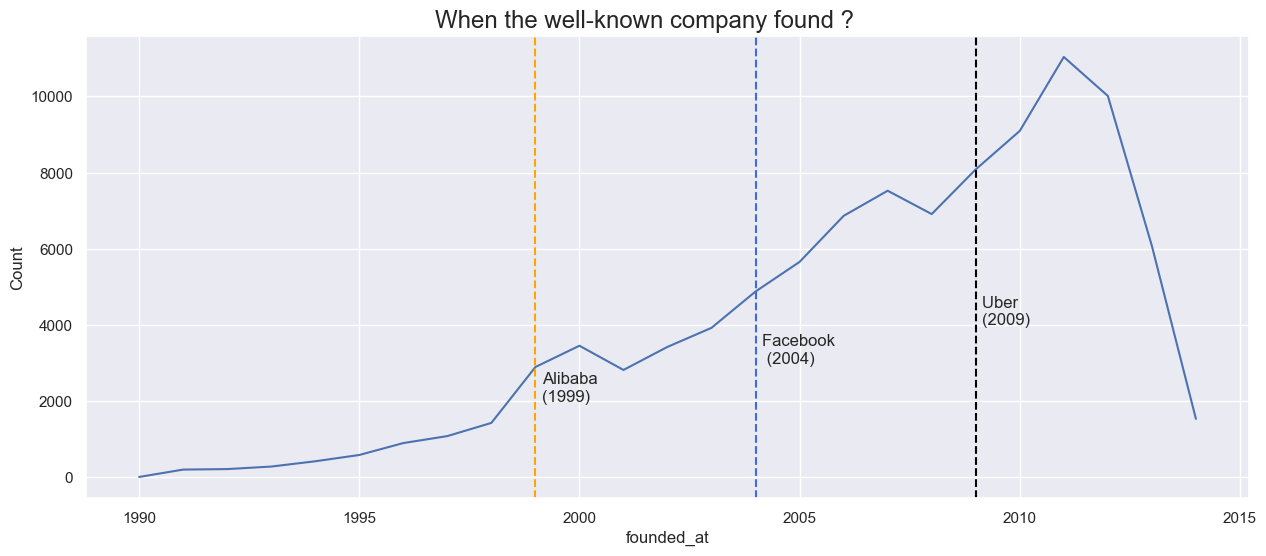

In [187]:
plt.rcParams['figure.figsize'] = 15,6
df_full['name'][df_full["founded_at"].dt.year >= 1990].groupby(df_full["founded_at"].dt.year).count().plot(kind="line")
plt.ylabel('Count')

plt.axvline(Facebook_founded_year,color='royalblue',linestyle ="--")
plt.text(Facebook_founded_year+0.15, 3000,"Facebook \n (2004)")

plt.axvline(Uber_founded_year,color='black',linestyle ="--")
plt.text(Uber_founded_year+0.15, 4000,"Uber \n(2009)")

plt.axvline(Alibaba_founded_year,color='orange',linestyle ="--")
plt.text(Alibaba_founded_year+0.15, 2000,"Alibaba \n(1999)")


plt.title("When the well-known company found ?", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

### The markets

In [188]:
df_full['count'] = 1
country_market = df_full[['count','country_code','market']].groupby(['country_code','market']).agg({'count': 'sum'})
# Change: groupby state_office and divide by sum
country_market_pct = country_market.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
country_market_pct.reset_index(inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\339824326.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  country_market_pct = country_market.groupby(level=0).apply(lambda x:


In [189]:
USA_market_pct = country_market_pct[country_market_pct['country_code'] == "USA"]
USA_market_pct = USA_market_pct.sort_values('count',ascending = False)[0:10]

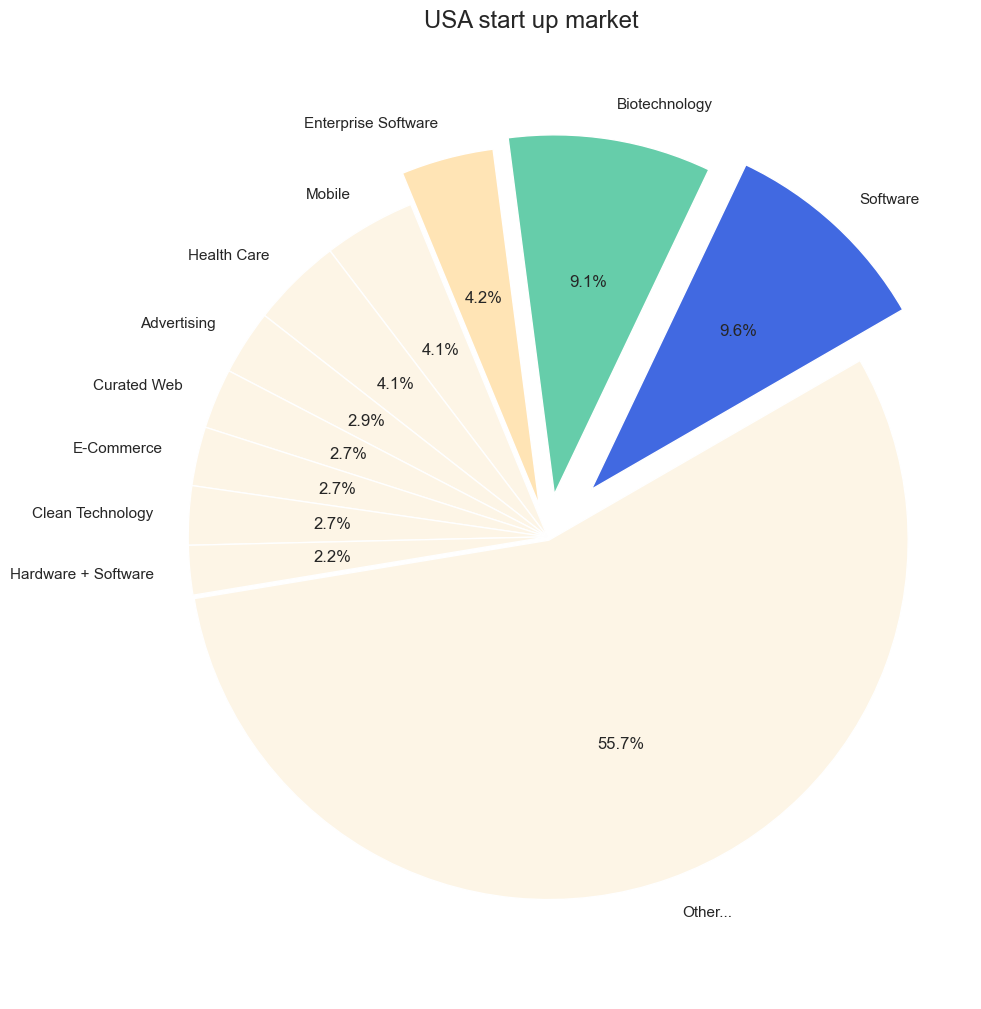

In [190]:
## USA
plt.rcParams['figure.figsize'] =10,10
labels = list(USA_market_pct['market'])+['Other...']
sizes = list(USA_market_pct['count'])+[100-USA_market_pct['count'].sum()]
explode = (0.18, 0.12, 0.09,0,0,0,0,0,0,0,0.01)
colors =  ['royalblue','mediumaquamarine','moccasin'] +['oldlace']*8

plt.pie(sizes, explode = explode, colors = colors ,labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("USA start up market", fontdict=None, position= [0.48,1.1], size = 'x-large')

plt.show()


### How much money

In [191]:
#Create the df_grouped data frame which will be used for external data analysis
df_grouped = df_full.groupby(df_full["founded_at"].dt.year)["funding_total_usd"].sum()
df_grouped

founded_at
1990       205909500
1991      8901484873
1992      8057518008
1993     17825153905
1994     16934811392
1995     25451402526
1996     38136106768
1997     52350376215
1998     81268762033
1999    168529098443
2000    168282162698
2001    162132973190
2002    194858682529
2003    328955688913
2004    349801617708
2005    349930518587
2006    394532356895
2007    508688996149
2008    300408598205
2009    292717792366
2010    192033550194
2011    164668759813
2012     98656922054
2013     32200163558
2014      4348126652
Name: funding_total_usd, dtype: int64

In [192]:
#Top invested categories, can be compared with the graph above including the total number of startups
df_full.groupby('market').sum()['funding_total_usd'].sort_values(ascending=False).head()

C:\Users\piotr\AppData\Local\Temp\ipykernel_30608\1368089779.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_full.groupby('market').sum()['funding_total_usd'].sort_values(ascending=False).head()


market
Biotechnology       406360495392
Software            243277172537
Clean Technology    219714708786
Health Care         193298115746
E-Commerce          178053496847
Name: funding_total_usd, dtype: int64

### Country Analyses

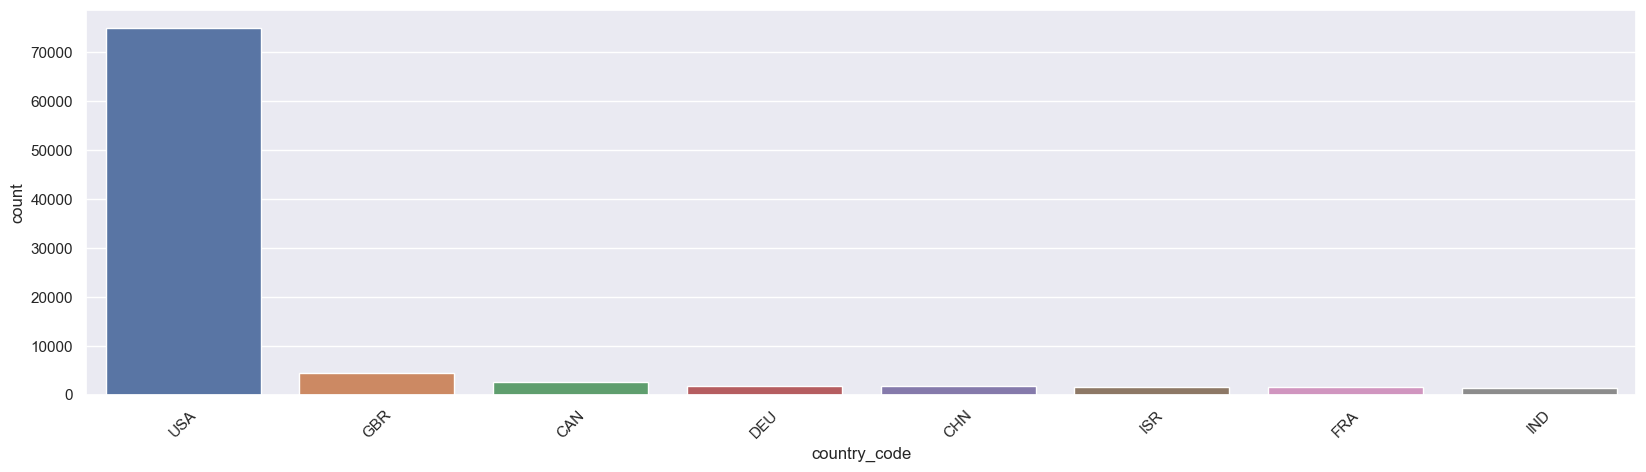

In [193]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='country_code', data = df_full, order=df_full['country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

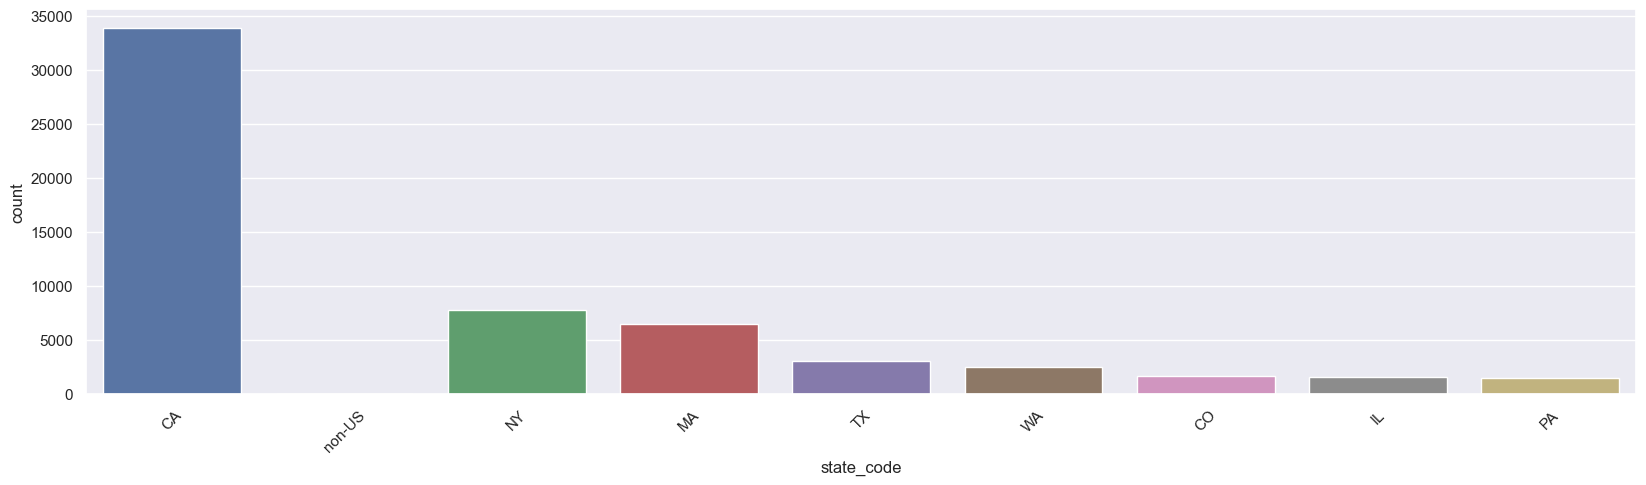

In [194]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='state_code', data = df_full[(df_full['country_code'] =='USA')], order=df_full['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()